In [1]:
import sys
print(sys.version)
print(sys.path)

3.6.12 (default, Dec 20 2020, 10:59:16) 
[GCC Apple LLVM 12.0.0 (clang-1200.0.32.28)]
['/Users/tokudo/Develop/grips/unicorn/notebooks', '/Users/tokudo/.pyenv/versions/3.6.12/lib/python36.zip', '/Users/tokudo/.pyenv/versions/3.6.12/lib/python3.6', '/Users/tokudo/.pyenv/versions/3.6.12/lib/python3.6/lib-dynload', '', '/Users/tokudo/Develop/grips/venv/lib/python3.6/site-packages', '/Users/tokudo/Develop/grips/grina', '/Users/tokudo/Develop/grips/venv/lib/python3.6/site-packages/IPython/extensions', '/Users/tokudo/.ipython', '/Users/tokudo/.local/lib/python3.6/site-packages']


In [2]:
import pandas as pd
import numpy as np
import os
import networkx as nx
import grina
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = ['Times New Roman']
plt.rcParams['axes.facecolor'] = "white"

In [3]:
out_dir = os.path.join("..", "out", "202202")
out_dir_names = ["edgelist", "features", "adjacency"]
for out_dir_name in out_dir_names:
    out_path = os.path.join(out_dir, out_dir_name)
    if not os.path.exists(out_path):
        os.makedirs(out_path)

In [4]:
def trans2float(x):
    y = x[1:]
    return float(y)

def clean(element):
    return element.strip()

def preprocess(data_df, date_format):
    return_df = data_df.copy()
    return_df["Valuation($B) flaot"] = return_df['Valuation ($B) '].apply(trans2float)
    return_df["DateTime Joined"] = return_df["Date Added"].apply(lambda x: datetime.datetime.strptime(x, date_format))
    # Unicornに重複がある場合に、suffixとして"_"を付与。
    duplicated_company_idx = (return_df["Company"].duplicated(), "Company")
    return_df.loc[duplicated_company_idx] = return_df.loc[duplicated_company_idx].apply(func=lambda x: str(x) + "+")
    return return_df

In [5]:
fpath = os.path.join("..", "data", "cb-insights_global-unicorn-club_2022.csv")
df = pd.read_csv(fpath, converters={"Select Investors": lambda x: x.split(",")})
df = preprocess(df, "%Y/%m/%d")
df.head()

,Company,Valuation ($B),Date Added,Country,Category,Select Investors,Valuation($B) flaot,DateTime Joined
0,Bytedance,$140.00,2017/4/7,China,Artificial intelligence,"[Sequoia Capital China, SIG Asia Investments,...",140.0,2017-04-07
1,SpaceX,$100.30,2012/12/1,United States,Other,"[Founders Fund, Draper Fisher Jurvetson, Rot...",100.3,2012-12-01
2,Stripe,$95.00,2014/1/23,United States,Fintech,"[Khosla Ventures, LowercaseCapital, capitalG]",95.0,2014-01-23
3,Klarna,$45.60,2011/12/12,Sweden,Fintech,"[Institutional Venture Partners, Sequoia Capi...",45.6,2011-12-12
4,Epic Games,$42.00,2018/10/26,United States,Other,"[Tencent Holdings, KKR, Smash Ventures]",42.0,2018-10-26


In [116]:
n_investors = df["Select Investors"].apply(lambda x: len(x))
n_investors.mean()

2.83

In [6]:
df["Valuation($B) flaot"].describe()

count    1000.000000
mean        3.307270
std         7.405112
min         1.000000
25%         1.070000
50%         1.600000
75%         3.100000
max       140.000000
Name: Valuation($B) flaot, dtype: float64

In [7]:
def unicorn_investor_edgelist(data_df):
    # UnicornとInvestorのエッジリストの作成
    r_comps, r_invests = [], []
    for company, investors in data_df[["Company", "Select Investors"]].values.tolist():
        n_rows = len(investors)
        comps = np.full(n_rows, company)
        r_comps += comps.tolist()
        r_invests += investors
    r_comps = list(map(clean, r_comps))
    r_invests = list(map(clean, r_invests))

    # Unicornで投資を行っている企業が存在するため、2部グラフにするためにInvester&Unicornの場合はInvester名に"_"を追加
    for i, invest in enumerate(r_invests):
        if invest in r_comps:
            r_invests[i] = invest + "_"

    edgelist_df = pd.DataFrame(
        {
            "Company": r_comps,
            "Investor": r_invests
        }
    )
    return edgelist_df

In [8]:
rdf = unicorn_investor_edgelist(df)
rdf.head()

,Company,Investor
0,Bytedance,Sequoia Capital China
1,Bytedance,SIG Asia Investments
2,Bytedance,Sina Weibo
3,Bytedance,Softbank Group
4,SpaceX,Founders Fund


In [9]:
B = nx.Graph()
B.add_nodes_from(rdf["Company"].unique().tolist(), bipartite=0)
B.add_nodes_from(rdf["Investor"].unique().tolist(), bipartite=1)
edges = [(comp, inve) for comp, inve in zip(rdf["Company"], rdf["Investor"])]
B.add_edges_from(edges)

In [10]:
from networkx.algorithms import bipartite
company_graph = bipartite.weighted_projected_graph(B, set(rdf["Company"].tolist()))
investor_graph = bipartite.weighted_projected_graph(B, set(rdf["Investor"].tolist()))
company_graph_df = nx.to_pandas_edgelist(company_graph)
investor_graph_df = nx.to_pandas_edgelist(investor_graph)
bipartite_graph_df = nx.to_pandas_edgelist(B)

In [11]:
print("ファイルを出力しますか？[y/n]")
b = input()
if b == "y":
    bipartite_graph_df.to_csv(os.path.join(out_dir, "edgelist", "bipartite_graph.csv"))
    company_graph_df.to_csv(os.path.join(out_dir, "edgelist", "company_graph.csv"))
    investor_graph_df.to_csv(os.path.join(out_dir, "edgelist", "investor_graph.csv"))
    print("Exported!!")

ファイルを出力しますか？[y/n]


# 2部グラフ分析

In [12]:
vc_invest_df = pd.merge(bipartite_graph_df, df, left_on="source", right_on="Company", how="left")
vc_invest_df.drop(["Select Investors", "source"], axis=1, inplace=True)
vc_invest_df.head()

,target,Company,Valuation ($B),Date Added,Country,Category,Valuation($B) flaot,DateTime Joined
0,Sequoia Capital China,Bytedance,$140.00,2017/4/7,China,Artificial intelligence,140.0,2017-04-07
1,SIG Asia Investments,Bytedance,$140.00,2017/4/7,China,Artificial intelligence,140.0,2017-04-07
2,Sina Weibo,Bytedance,$140.00,2017/4/7,China,Artificial intelligence,140.0,2017-04-07
3,Softbank Group,Bytedance,$140.00,2017/4/7,China,Artificial intelligence,140.0,2017-04-07
4,Founders Fund,SpaceX,$100.30,2012/12/1,United States,Other,100.3,2012-12-01


In [13]:
analysis_invest_df = vc_invest_df.groupby("target", as_index=False).agg(
    {
        "Valuation($B) flaot": ["sum", "count", "mean"],
        "Country": [lambda x: len(x.unique()), set],
        "Category": [lambda x: len(x.unique()), set],
        "Company": [lambda x: len(x.unique()), set],
        "DateTime Joined": "min",
    }
)
analysis_invest_df.head()

target Valuation($B) flaot                 Country  \
                                   sum count   mean <lambda_0>   
0    .406 Ventures                1.70     1  1.700          1   
1      01 Advisors                9.35     2  4.675          1   
2         10T Fund                7.10     1  7.100          1   
3              14W                2.50     2  1.250          1   
4  14W. ForgeLight                1.10     1  1.100          1   

                      Category                                          \
                set <lambda_0>                                     set   
0   {United States}          1           {Data management & analytics}   
1   {United States}          2                     {Hardware, Fintech}   
2   {United States}          1                               {Fintech}   
3   {United States}          2  {Health, Internet software & services}   
4  {United Kingdom}          1                               {Fintech}   

     Company                         DateTime Joined  
  <lambda_0>                     set             min  
0          1                {Reltio}      2021-11-04  
1          2      {Tipalti, Density}      2020-10-06  
2          1                {Gemini}      2021-11-19  
3          2  {K Health, Fever Labs}      2021-01-19  
4          1    {The Bank of London}      2021-11-30

In [14]:
columns = ["Investor", "Total valuation($B)", "Valuation count", "Mean valuation($B)", "#countries", "Country set", "#industries", "Industry set", "#unicorns", "Unicorn set", "Oldest datetime joined"]
analysis_invest_df.columns = analysis_invest_df.columns.to_flat_index()
analysis_invest_df.columns = columns
analysis_invest_df.to_csv(os.path.join(out_dir, "features", "investment_info.csv"))
analysis_invest_df.head()

,Investor,Total valuation($B),Valuation count,Mean valuation($B),#countries,Country set,#industries,Industry set,#unicorns,Unicorn set,Oldest datetime joined
0,.406 Ventures,1.70,1,1.700,1,{United States},1,{Data management & analytics},1,{Reltio},2021-11-04
1,01 Advisors,9.35,2,4.675,1,{United States},2,"{Hardware, Fintech}",2,"{Tipalti, Density}",2020-10-06
2,10T Fund,7.10,1,7.100,1,{United States},1,{Fintech},1,{Gemini},2021-11-19
3,14W,2.50,2,1.250,1,{United States},2,"{Health, Internet software & services}",2,"{K Health, Fever Labs}",2021-01-19
4,14W. ForgeLight,1.10,1,1.100,1,{United Kingdom},1,{Fintech},1,{The Bank of London},2021-11-30


# 中心性
## 投資家のグラフ

In [15]:
def get_centrality(G):
    if nx.is_weighted(G):
        print("重み付きグラフです。")
        weight_key = "weight"
    else:
        print("非重み付きグラフです。")
        weight_key = None

    degrees = nx.degree_centrality(G)
    betweens = nx.betweenness_centrality(G, weight=weight_key)
    eigens = nx.eigenvector_centrality(G, max_iter=1000, weight=weight_key)
    closeness = nx.closeness_centrality(G, distance=weight_key)
    page_ranks = nx.pagerank(G, max_iter=1000, weight=weight_key)
    centra_dict = {
        "Degree Centrality": degrees,
        "Betweenness Centrality": betweens,
        "Eigen Centrality": eigens,
        "Closeness Centrality": closeness,
        "Page Rank": page_ranks,
    }
    if type(G) == nx.DiGraph:
        in_degrees = nx.in_degree_centrality(G)
        out_degrees = nx.out_degree_centrality(G)
        elongations = grina.get_elongation(G)
        expansions = grina.get_degree_expansion(G)
        teacher_discs = grina.node_teacher_disciple_degree(G)
        colleagues = grina.node_colleague_degree(G)
        unidir_density = grina.node_unidirect_density(G)
        bidir_density = grina.node_bidirect_density(G)
        centra_dict["In-degree Centrality"] = in_degrees
        centra_dict["Out-degree Centrality"] = out_degrees
        centra_dict["Elongation"] = elongations
        centra_dict["Expansion"] = expansions
        centra_dict["Teacher Disciple Degree"] = teacher_discs
        centra_dict["Colleague Degree"] = colleagues
        centra_dict["Unidirect Density"] = unidir_density
        centra_dict["Bidirect Density"] = bidir_density
    return pd.DataFrame.from_dict(centra_dict)

In [16]:
investor_centrality_df = get_centrality(investor_graph).reset_index().rename({"index": "Investor"}, axis=1)
investor_centrality_df = pd.merge(investor_centrality_df, analysis_invest_df, on="Investor")
investor_centrality_df.head()

重み付きグラフです。


,Investor,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,Total valuation($B),Valuation count,Mean valuation($B),#countries,Country set,#industries,Industry set,#unicorns,Unicorn set,Oldest datetime joined
0,Yunfeng Capital,0.005017,0.005444,0.004526,0.204678,0.001301,13.23,3,4.410000,1,{China},3,"{Artificial intelligence, Consumer & retail, A...",3,"{Weilong, Banma Network Technologies, DeepBlue...",2018-04-16
1,Francisco Partners,0.001672,0.000046,0.003757,0.208173,0.000378,1.00,1,1.000000,1,{United States},1,{Internet software & services},1,{News Break},2021-01-07
2,Alpargatas,0.001672,0.000000,0.005313,0.217213,0.000368,1.00,1,1.000000,1,{United States},1,{Consumer & retail},1,{Rothy's},2021-12-21
3,L Catterton,0.003344,0.000264,0.000703,0.182681,0.000774,3.10,2,1.550000,1,{United States},1,{E-commerce & direct-to-consumer},2,"{Tonal, Il Makiage}",2021-03-31
4,Salesforce Ventures,0.010870,0.006399,0.021733,0.210361,0.002153,21.90,7,3.128571,4,"{Israel, United States, Spain, Germany}",4,"{Supply chain, logistics, & delivery, Data man...",7,"{Talkdesk, OwnBackup, Copado, wefox, Bringg, A...",2018-10-03


## 企業のネットワーク


In [17]:
company_centrality_df = get_centrality(company_graph)
company_centrality_df = company_centrality_df.reset_index().rename({"index": "Company"},axis=1) 
company_centrality_df = pd.merge(company_centrality_df, df, on="Company")
company_centrality_df.head()

重み付きグラフです。


,Company,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,Valuation ($B),Date Added,Country,Category,Select Investors,Valuation($B) flaot,DateTime Joined
0,Everlaw,0.049049,0.002196,0.023486,0.364771,0.001450,$2.00,2021/11/2,United States,Internet software & services,"[K9 Ventures, Menlo Ventures, Andreessen Hor...",2.00,2021-11-02
1,IRL,0.018018,0.001768,0.002620,0.311693,0.000814,$1.17,2021/6/15,United States,Internet software & services,"[Goodwater Capital, Floodgate, Founders Fund]",1.17,2021-06-15
2,Xiaohongshu,0.025025,0.001261,0.003732,0.310133,0.001113,$20.00,2016/3/31,China,E-commerce & direct-to-consumer,"[GGV Capital, ZhenFund, Tencent]",20.00,2016-03-31
3,Orca Bio,0.037037,0.003269,0.008467,0.346862,0.001384,$1.00,2020/6/17,United States,Health,"[Lightspeed Venture Partners, Data Collective...",1.00,2020-06-17
4,MindTickle,0.067067,0.005188,0.099697,0.370817,0.001931,$1.20,2021/8/3,United States,Internet software & services,"[Qualcomm Ventures, Accel, Canaan Partners]",1.20,2021-08-03


## 企業メモ
* Pony.aiは自動運転自動車の会社
* Ziroomは賃貸掲載サイトの運営会社（スーモやホームズみたいなサイトの中国版？）
* Rappiはコロンビアの会社で、買い物代行。Uber eatに近いサービスだと思う。

# コンポーネント

In [18]:
def describe_components(G):
    n_comps = nx.number_connected_components(G)
    print("コンポーネント数: {}".format(n_comps))
    print("ノード数に対するコンポーネント数の割合: {0:.2%}".format(n_comps / len(G)))
    S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
    comp_sizes = [len(s) for s in S]
    print("投資家コンポーネント上位10件のサイズ")
    print(np.sort(comp_sizes)[::-1][:10])
    comp_sizes = np.sort(comp_sizes)[::-1]
    plt.plot(comp_sizes)
    print("ネットワーク密度: {0:.2%}".format(nx.density(S[0])))

コンポーネント数: 97
ノード数に対するコンポーネント数の割合: 8.10%
投資家コンポーネント上位10件のサイズ
[967   5   5   5   4   4   3   3   3   3]
ネットワーク密度: 0.50%


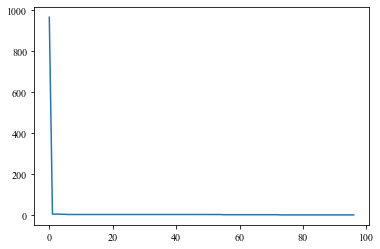

In [19]:
describe_components(investor_graph)

コンポーネント数: 97
ノード数に対するコンポーネント数の割合: 9.70%
投資家コンポーネント上位10件のサイズ
[898   2   2   2   2   2   2   1   1   1]
ネットワーク密度: 3.44%


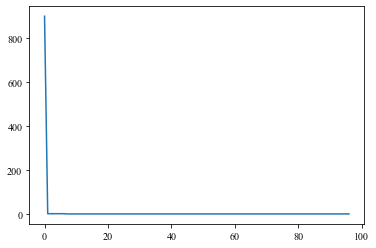

In [20]:
describe_components(company_graph)

# 基本情報の出力
国ごとのバリュエーション、Industryごとのバリュエーションを出力

In [21]:
df.sort_values(by=["Date Added"])

,Company,Valuation ($B),Date Added,Country,Category,Select Investors,Valuation($B) flaot,DateTime Joined
603,Veepee,$1.38,2007/7/20,France,E-commerce & direct-to-consumer,"[Summit Partners, Qatar Holding]",1.38,2007-07-20
3,Klarna,$45.60,2011/12/12,Sweden,Fintech,"[Institutional Venture Partners, Sequoia Capi...",45.60,2011-12-12
105,Vice Media,$5.70,2011/4/2,United States,Internet software & services,"[Technology Crossover Ventures, A&E Televisio...",5.70,2011-04-02
1,SpaceX,$100.30,2012/12/1,United States,Other,"[Founders Fund, Draper Fisher Jurvetson, Rot...",100.30,2012-12-01
380,Avant,$2.00,2012/12/17,United States,Artificial intelligence,"[RRE Ventures, Tiger Global, August Capital]",2.00,2012-12-17
...,...,...,...,...,...,...,...,...
635,Loadsmart,$1.30,2022/2/1,United States,"Supply chain, logistics, & delivery","[Chromo Invest, Maersk Growth, BlackRock]",1.30,2022-02-01
507,Wayflyer,$1.60,2022/2/1,Ireland,Fintech,"[QED Investors, DST Global, Left Lane Capital]",1.60,2022-02-01
998,Betterfly,$1.00,2022/2/1,Chile,Artificial intelligence,"[QED Investors, DST Global, Endeavor]",1.00,2022-02-01
482,Productboard,$1.70,2022/2/2,United States,Internet software & services,"[Index Ventures, Kleiner Perkins Caufield & B...",1.70,2022-02-02


In [22]:
stat_ind = ["mean", "sum", "min", "max", "count"]
country_group = df.groupby("Country").agg(stat_ind)
country_group.head()
cg_df = pd.DataFrame(country_group["Valuation($B) flaot"][stat_ind].values, columns=stat_ind, index=country_group.index)
cg_df.sort_values(by=["sum"], ascending=False, inplace=True)
cg_df.head()

,mean,sum,min,max,count
Country,,,,,
United States,3.409294,1738.74,1.0,100.3,510.0
China,3.410359,569.53,1.0,140.0,167.0
United Kingdom,4.622564,180.28,1.0,40.0,39.0
India,3.035085,179.07,1.0,21.0,59.0
Germany,2.888000,72.20,1.0,11.0,25.0


In [23]:
industry_group = df.groupby("Category").agg(stat_ind)
industry_group.head()
ig_df = pd.DataFrame(industry_group["Valuation($B) flaot"][stat_ind].values, columns=stat_ind, index=industry_group.index)
ig_df.sort_values(by=["sum"], ascending=False, inplace=True)
ig_df.head()

,mean,sum,min,max,count
Category,,,,,
Fintech,3.921311,807.79,1.0,95.0,206.0
Internet software & services,2.952228,543.21,1.0,40.0,184.0
E-commerce & direct-to-consumer,2.955185,319.16,1.0,20.0,108.0
Artificial intelligence,4.077143,313.94,1.0,140.0,77.0
Other,4.795455,263.75,1.0,100.3,55.0


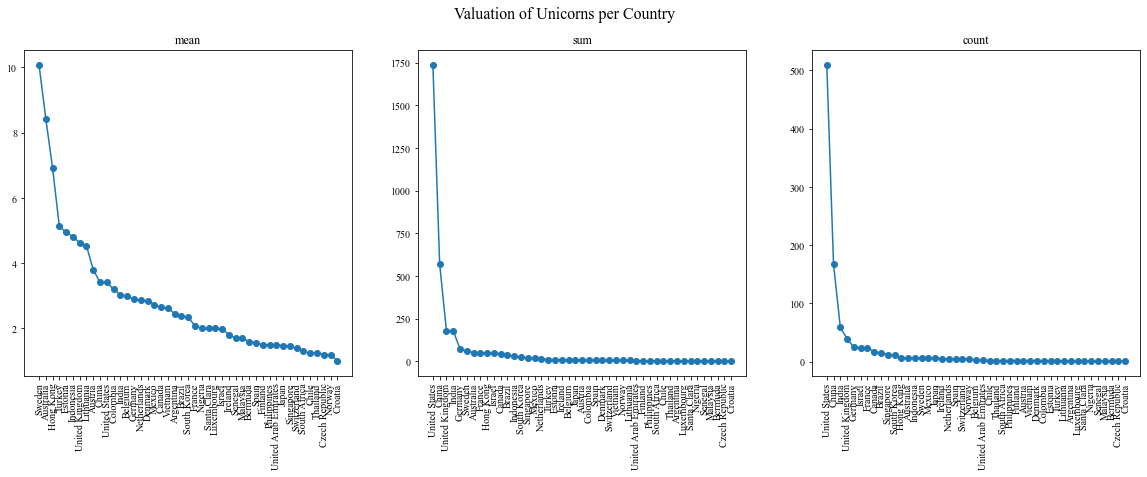

Complete output to ../out/202202/features/value_per_country.png


In [24]:
nrows = 1
ncols = 3
y = cg_df["mean"].values
x = cg_df.index.to_numpy()
fig = plt.figure(figsize=(20, 6))
fig.suptitle("Valuation of Unicorns per Country", fontsize=16)
for ind, col in enumerate(["mean", "sum", "count"]):
    ax = fig.add_subplot(nrows, ncols, ind+1)
    cg_df.sort_values(by=[col], ascending=False, inplace=True)
    y = cg_df[col].values
    x = cg_df.index.to_numpy()
    ax.plot(x, y, marker="o")
    ax.set_title(f"{col}")
    plt.xticks(rotation=90)
plt.show()
fpath = os.path.join(out_dir, "features", "value_per_country.png")
fig.savefig(fpath)
print("Complete output to {}".format(fpath))

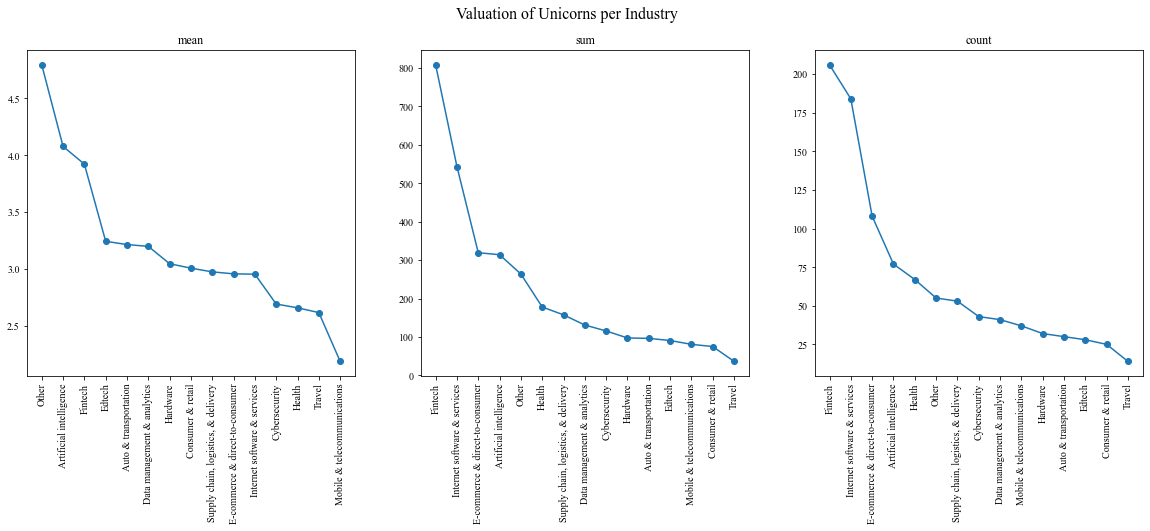

Complete output to ../out/202202/features/value_per_industry.png


In [25]:
nrows = 1
ncols = 3
fig = plt.figure(figsize=(20, 6))
fig.suptitle("Valuation of Unicorns per Industry", fontsize=16)
for ind, col in enumerate(["mean", "sum", "count"]):
    ax = fig.add_subplot(nrows, ncols, ind+1)
    ig_df.sort_values(by=[col], ascending=False, inplace=True)
    y = ig_df[col].values
    x = ig_df.index.to_numpy()
    ax.plot(x, y, marker="o")
    ax.set_title(f"{col}")
    plt.xticks(rotation=90)
plt.show()
fpath = os.path.join(out_dir, "features", "value_per_industry.png")
fig.savefig(fpath)
print("Complete output to {}".format(fpath))

[]

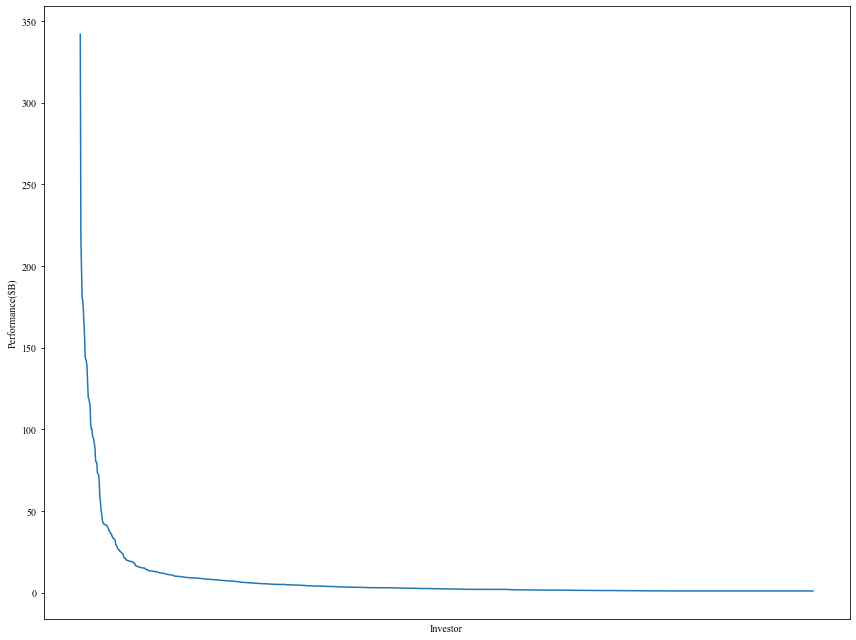

In [26]:
# 投資家のパフォーマンスグラフ。
analysis_invest_df.sort_values("Total valuation($B)", ascending=False).plot(
    x="Investor", y="Total valuation($B)", figsize=(12, 9), rot=90, ylabel="Performance($B)", xticks=[],
    legend=False, fontsize=10
)
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "features", "investor_valuation.png"), facecolor="white")
plt.plot()

[]

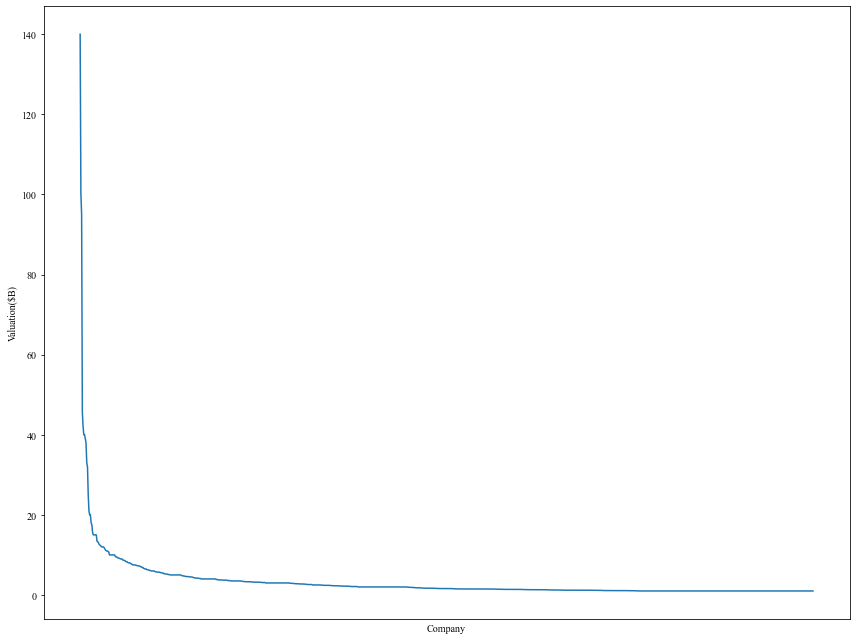

In [27]:
# ユニコーンのバリュエーション
sorted_unicorn_df = df.sort_values("Valuation($B) flaot", ascending=False)
sorted_unicorn_df.plot(x="Company", y="Valuation($B) flaot", figsize=(12, 9), xticks=[], legend=False, ylabel="Valuation($B)")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "features", "unicorn_valuation.png"), facecolor="white")
plt.plot()

# 時系列可視化

In [28]:
print(len(df))
tdf = df.set_index("DateTime Joined")
tdf

1000


,Company,Valuation ($B),Date Added,Country,Category,Select Investors,Valuation($B) flaot
DateTime Joined,,,,,,,
2017-04-07,Bytedance,$140.00,2017/4/7,China,Artificial intelligence,"[Sequoia Capital China, SIG Asia Investments,...",140.0
2012-12-01,SpaceX,$100.30,2012/12/1,United States,Other,"[Founders Fund, Draper Fisher Jurvetson, Rot...",100.3
2014-01-23,Stripe,$95.00,2014/1/23,United States,Fintech,"[Khosla Ventures, LowercaseCapital, capitalG]",95.0
2011-12-12,Klarna,$45.60,2011/12/12,Sweden,Fintech,"[Institutional Venture Partners, Sequoia Capi...",45.6
2018-10-26,Epic Games,$42.00,2018/10/26,United States,Other,"[Tencent Holdings, KKR, Smash Ventures]",42.0
...,...,...,...,...,...,...,...
2022-01-26,Fever Labs,$1.00,2022/1/26,United States,Internet software & services,"[Accel, 14W, GS Growth]",1.0
2022-01-26,Minio,$1.00,2022/1/26,United States,Data management & analytics,"[General Catalyst, Nexus Venture Partners, D...",1.0
2022-01-27,Esusu,$1.00,2022/1/27,United States,Fintech,"[Next Play Ventures, Zeal Capital Partners, ...",1.0


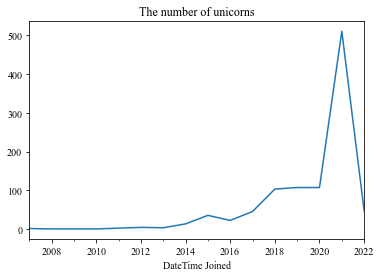

In [29]:
gdf = df.groupby(pd.Grouper(key="DateTime Joined", freq="Y")).agg("count")
gdf = gdf.reset_index().set_index("DateTime Joined")
gdf["Company"].plot(title="The number of unicorns")
plt.savefig(os.path.join(out_dir, "features", "n_unicorns_time_change.png"))

In [30]:
df.loc[:, "Year Joined"] = df["DateTime Joined"].apply(lambda x: x.year)
df.head()

,Company,Valuation ($B),Date Added,Country,Category,Select Investors,Valuation($B) flaot,DateTime Joined,Year Joined
0,Bytedance,$140.00,2017/4/7,China,Artificial intelligence,"[Sequoia Capital China, SIG Asia Investments,...",140.0,2017-04-07,2017
1,SpaceX,$100.30,2012/12/1,United States,Other,"[Founders Fund, Draper Fisher Jurvetson, Rot...",100.3,2012-12-01,2012
2,Stripe,$95.00,2014/1/23,United States,Fintech,"[Khosla Ventures, LowercaseCapital, capitalG]",95.0,2014-01-23,2014
3,Klarna,$45.60,2011/12/12,Sweden,Fintech,"[Institutional Venture Partners, Sequoia Capi...",45.6,2011-12-12,2011
4,Epic Games,$42.00,2018/10/26,United States,Other,"[Tencent Holdings, KKR, Smash Ventures]",42.0,2018-10-26,2018


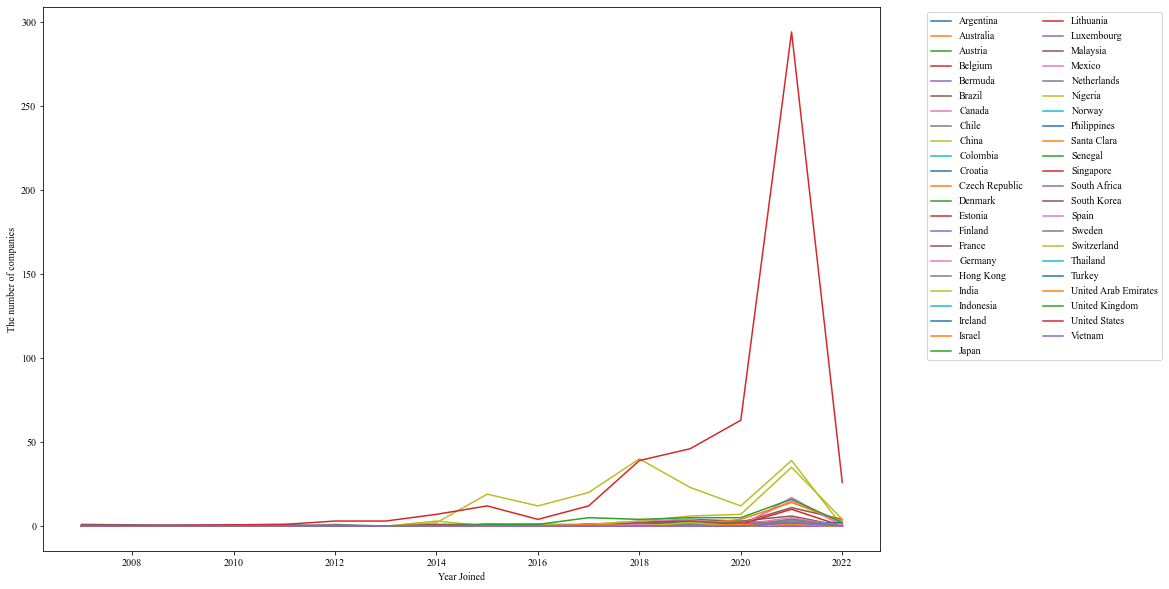

In [31]:
country_group_df = df.groupby(["Year Joined", "Country"], as_index=False).count()
country_series_df = country_group_df.pivot(index="Year Joined", columns="Country", values="Company").fillna(0)
country_series_df.plot(figsize=(15, 10))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left", ncol=2)
plt.ylabel("The number of companies")
fpath = os.path.join(out_dir, "features", "company_number_series_country.png")
plt.savefig(fpath, bbox_inches='tight')
country_series_df.to_csv(os.path.join(out_dir, "features", "company_number_series_country.csv"))

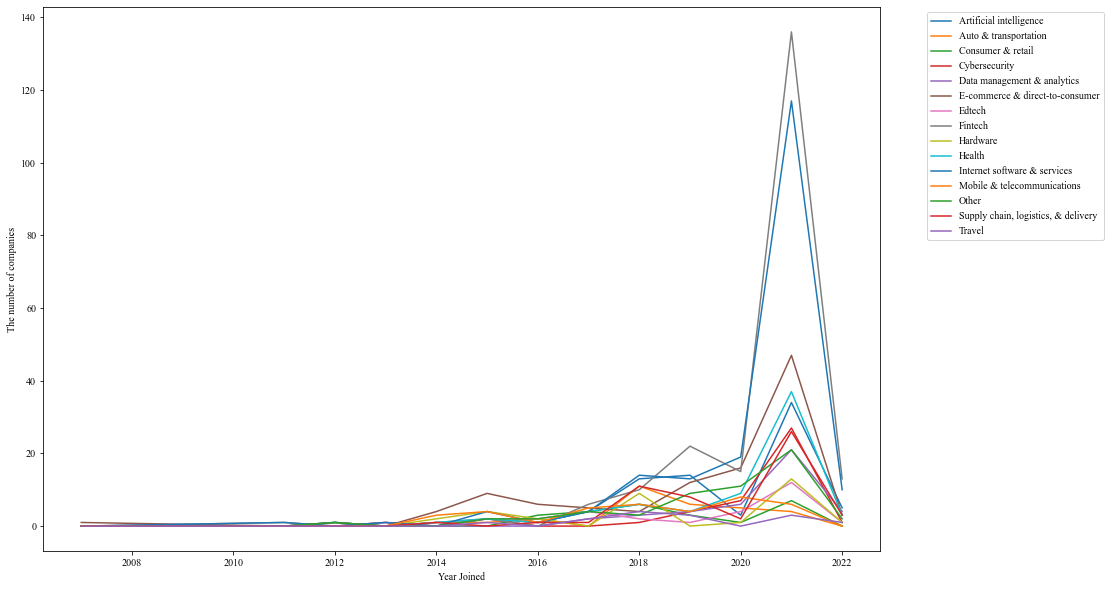

In [32]:
industry_group_df = df.groupby(["Year Joined", "Category"], as_index=False).count()
industry_series_df = industry_group_df.pivot(index="Year Joined", columns="Category", values="Company").fillna(0)
industry_series_df.plot(figsize=(15, 10))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left", ncol=1)
plt.ylabel("The number of companies")
fpath = os.path.join(out_dir, "features", "industry_number_series_country.png")
plt.savefig(fpath, bbox_inches='tight')
industry_series_df.to_csv(os.path.join(out_dir, "features", "industry_number_series_country.csv"))

In [33]:
df.head()

,Company,Valuation ($B),Date Added,Country,Category,Select Investors,Valuation($B) flaot,DateTime Joined,Year Joined
0,Bytedance,$140.00,2017/4/7,China,Artificial intelligence,"[Sequoia Capital China, SIG Asia Investments,...",140.0,2017-04-07,2017
1,SpaceX,$100.30,2012/12/1,United States,Other,"[Founders Fund, Draper Fisher Jurvetson, Rot...",100.3,2012-12-01,2012
2,Stripe,$95.00,2014/1/23,United States,Fintech,"[Khosla Ventures, LowercaseCapital, capitalG]",95.0,2014-01-23,2014
3,Klarna,$45.60,2011/12/12,Sweden,Fintech,"[Institutional Venture Partners, Sequoia Capi...",45.6,2011-12-12,2011
4,Epic Games,$42.00,2018/10/26,United States,Other,"[Tencent Holdings, KKR, Smash Ventures]",42.0,2018-10-26,2018


# ネットワークに時系列の要素を追加
カンパニーグラフは知識の流れを表していると解釈することができる。Date Joinedが遅い企業は、早い企業から知識を共有されていると考える。
そうした場合にどこの企業からどこの企業にVCを介して知識が伝播しているかを可視化する。

## ユニコーンネットワーク

In [34]:
company_graph_df

,source,target,weight
0,Everlaw,Databricks,1
1,Everlaw,Instabase,1
2,Everlaw,Phantom,1
3,Everlaw,SnapLogic,1
4,Everlaw,Starburst,1
...,...,...,...
13841,MessageBird,Snapdocs,1
13842,Rec Room,Snapdocs,1
13843,Rec Room,Druva,1
13844,Snapdocs,Druva,1


In [35]:
uc_date_columns = ["Company", "Date Added", "Country", "Category", "Valuation($B) flaot"]
uc_date = df.loc[:, uc_date_columns]
uc_date.loc[:, "DateTime Joined"] = uc_date["Date Added"].apply(lambda x: datetime.datetime.strptime(x, "%Y/%m/%d"))
uc_date.set_index("Company", inplace=True)
elem_dict = uc_date.to_dict("index")

In [36]:
def to_directed_by_datetime_joined(graph_df, elem_dict):
    """方向付きのネットワークに変換するメソッド."""
    sources, targets, weights = [], [], []

    for source, target, weight in graph_df.values:

            if elem_dict[source]["DateTime Joined"] > elem_dict[target]["DateTime Joined"]:
                sources.append(target)
                targets.append(source)
                weights.append(weight)
            elif elem_dict[source]["DateTime Joined"] == elem_dict[target]["DateTime Joined"]:
                print(
                    "They have the same DataTime Joined, ({}, {}) at {}".format(
                        source, target, elem_dict[source]["DateTime Joined"]
                    )
                )
            else:
                sources.append(source)
                targets.append(target)
                weights.append(weight)

    dgraph_df = pd.DataFrame({
        "source": sources, "target": targets, "weight": weights
    })
    print("入力エッジ数: {}".format(len(graph_df)))
    print("出力エッジ数: {}".format(len(dgraph_df)))
    return dgraph_df

In [37]:
comp_dgraph_df = to_directed_by_datetime_joined(company_graph_df, elem_dict)

They have the same DataTime Joined, (goPuff, MessageBird) at 2020-10-08 00:00:00
They have the same DataTime Joined, (Five Star Business Finance, Getir) at 2021-03-26 00:00:00
They have the same DataTime Joined, (Urban Company, KRY) at 2021-04-27 00:00:00
They have the same DataTime Joined, (CRED, Sendbird) at 2021-04-06 00:00:00
They have the same DataTime Joined, (Pacaso, Feedzai) at 2021-03-24 00:00:00
They have the same DataTime Joined, (apna, Mobile Premier League) at 2021-09-15 00:00:00
They have the same DataTime Joined, (Veriff, Fever Labs) at 2022-01-26 00:00:00
They have the same DataTime Joined, (Veriff, CaptivateIQ) at 2022-01-26 00:00:00
They have the same DataTime Joined, (Savage X Fenty, BitPanda) at 2021-03-16 00:00:00
They have the same DataTime Joined, (CarDekho, MobiKwik) at 2021-10-13 00:00:00
They have the same DataTime Joined, (ClickHouse, YugaByte) at 2021-10-28 00:00:00
They have the same DataTime Joined, (CaptivateIQ, Fever Labs) at 2022-01-26 00:00:00
They hav

In [38]:
# チェック用
print(elem_dict["Flexport"]["Date Added"])
# print(elem_dict["Knotel"]["Date Added"])
print(elem_dict["Gong"]["Date Added"])
print(elem_dict["VAST Data"]["Date Added"])
# print(elem_dict["Dave"]["Date Added"])
# print(elem_dict["Udemy"]["Date Added"])

2018/4/30
2020/8/12
2020/4/16


In [39]:
comp_dgraph = nx.from_pandas_edgelist(comp_dgraph_df, source="source", target="target", create_using=nx.DiGraph)

In [40]:
# 国・産業ごとにノードに色付けのためのCMAP生成
cmap = plt.get_cmap("tab20b")
country_l = df["Country"].unique()
industry_l = df["Category"].unique()
country_cmap = []
industry_cmap = []
val_size = []
max_val = df["Valuation($B) flaot"].max()
min_val = df["Valuation($B) flaot"].min()
diff = max_val - min_val
for n in comp_dgraph.nodes():
    industry = elem_dict[n]["Category"]
    ind_idx = np.where(industry_l == industry)
    country = elem_dict[n]["Country"]
    cou_idx = np.where(country_l == country)
    industry_cmap.append(cmap(ind_idx))
    country_cmap.append(cmap(cou_idx))
    val_size.append(
        100 + (elem_dict[n]["Valuation($B) flaot"] - min_val)/diff*900
    )

In [41]:
country_cmap = list(map(lambda x: tuple(x[0][0]), country_cmap))
industry_cmap = list(map(lambda x: tuple(x[0][0]), industry_cmap))

In [42]:
val_size[:10]

[339.568345323741,
 106.4748201438849,
 100.32374100719424,
 101.29496402877697,
 100.0,
 101.29496402877697,
 106.4748201438849,
 100.0,
 101.61870503597122,
 151.79856115107913]

In [43]:
# plt.figure(figsize=(100, 100))
# nx.draw_circular(comp_dgraph, font_size=8, node_size=val_size, node_color=country_cmap)
# plt.savefig(os.path.join(out_dir, "sen2jun_dgraph"))

In [44]:
comp_dgraph_centrality_df = get_centrality(comp_dgraph)
comp_dgraph_centrality_df = comp_dgraph_centrality_df.reset_index().rename({"index": "Company"}, axis=1)
comp_dgraph_centrality_df.head()
comp_dgraph_centrality_df = pd.merge(comp_dgraph_centrality_df, df, on="Company", how="left")

非重み付きグラフです。


In [45]:
comp_dgraph_centrality_df.to_csv(os.path.join(out_dir, "features", "directed_unicorn_centrality.csv"))

## VCネットワーク

In [46]:
investor_graph_df

,source,target,weight
0,Yunfeng Capital,Shang Qi Capital,1
1,Yunfeng Capital,Tencent Holdings,1
2,Yunfeng Capital,Meridian Capital,1
3,Yunfeng Capital,DESUN Capital,1
4,Yunfeng Capital,SDIC Innovation Investment Management,1
...,...,...,...
2500,Sapphire Ventures,Scale Venture Partners,1
2501,MMC Ventures,Unilever Ventures,1
2502,EQT Partners,Blackstone,1
2503,ZhenFund,K2 Ventures,1


In [47]:
datetime_df = analysis_invest_df[["Investor", "Oldest datetime joined"]]
datetime_df.columns = ["investor", "DateTime Joined"]
elem_dict = datetime_df.set_index("investor").to_dict("index")

In [48]:
investor_dgraph_df = to_directed_by_datetime_joined(investor_graph_df, elem_dict)

They have the same DataTime Joined, (Yunfeng Capital, Meridian Capital) at 2018-04-16 00:00:00
They have the same DataTime Joined, (Yunfeng Capital, DESUN Capital) at 2018-04-16 00:00:00
They have the same DataTime Joined, (Salesforce Ventures, DJF) at 2018-10-03 00:00:00
They have the same DataTime Joined, (Salesforce Ventures, Storm Ventures) at 2018-10-03 00:00:00
They have the same DataTime Joined, (HarbourVest Partners, The Rise Fund) at 2021-09-09 00:00:00
They have the same DataTime Joined, (Standard Crypto, Fabric Ventures) at 2021-10-04 00:00:00
They have the same DataTime Joined, (Invus Group, SWaN & Legend Ventures) at 2021-04-27 00:00:00
They have the same DataTime Joined, (Valor Equity Partners, Capricorn Investment Group) at 2021-07-28 00:00:00
They have the same DataTime Joined, (BP Ventures, SingulariTeam) at 2022-01-04 00:00:00
They have the same DataTime Joined, (Fifth Wall Ventures, OpenView Venture Partners) at 2019-05-07 00:00:00
They have the same DataTime Joined,

In [49]:
investor_dgraph = nx.from_pandas_edgelist(investor_dgraph_df, source="source", target="target", create_using=nx.DiGraph)

In [50]:
investor_dgraph_centrality_df = get_centrality(investor_dgraph)
investor_dgraph_centrality_df = investor_dgraph_centrality_df.reset_index().rename({"index": "Investor"}, axis=1)
investor_dgraph_centrality_df = pd.merge(investor_dgraph_centrality_df, analysis_invest_df, on="Investor", how="left")
investor_dgraph_centrality_df.to_csv(os.path.join(out_dir, "features", "directed_investor_centrality.csv"))
investor_dgraph_centrality_df.head()

非重み付きグラフです。


,Investor,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,...,Total valuation($B),Valuation count,Mean valuation($B),#countries,Country set,#industries,Industry set,#unicorns,Unicorn set,Oldest datetime joined
0,Yunfeng Capital,0.004415,0.000100,1.122387e-16,0.015724,0.000824,0.001104,0.003311,2,6,...,13.23,3,4.410000,1,{China},3,"{Artificial intelligence, Consumer & retail, A...",3,"{Weilong, Banma Network Technologies, DeepBlue...",2018-04-16
1,Shang Qi Capital,0.001104,0.000000,3.042577e-15,0.012169,0.000991,0.001104,0.000000,0,0,...,1.00,1,1.000000,1,{China},1,{Auto & transportation},1,{Banma Network Technologies},2018-09-13
2,Tencent Holdings,0.041943,0.003494,3.854413e-18,0.022935,0.002109,0.012141,0.029801,6,427,...,156.90,28,5.603571,6,"{France, United States, China, India, Australi...",10,"{Fintech, Artificial intelligence, Health, Aut...",28,"{Dxy.cn, Lydia, Dream11, Kuaikan Manhua, Enfla...",2016-08-04
3,SDIC Innovation Investment Management,0.001104,0.000000,3.042577e-15,0.012169,0.000991,0.001104,0.000000,0,0,...,1.00,1,1.000000,1,{China},1,{Auto & transportation},1,{Banma Network Technologies},2018-09-13
4,Hillhouse Capital Management,0.012141,0.000135,3.909567e-12,0.024991,0.001872,0.008830,0.003311,1,3,...,41.28,8,5.160000,4,"{India, Germany, China, Indonesia}",6,"{Supply chain, logistics, & delivery, E-commer...",8,"{Horizon Robotics, J&T Express, CarDekho, Haom...",2019-02-27


In [51]:
investor_dgraph_centrality_df.columns

Index(['Investor', 'Degree Centrality', 'Betweenness Centrality',
       'Eigen Centrality', 'Closeness Centrality', 'Page Rank',
       'In-degree Centrality', 'Out-degree Centrality', 'Elongation',
       'Expansion', 'Teacher Disciple Degree', 'Colleague Degree',
       'Unidirect Density', 'Bidirect Density', 'Total valuation($B)',
       'Valuation count', 'Mean valuation($B)', '#countries', 'Country set',
       '#industries', 'Industry set', '#unicorns', 'Unicorn set',
       'Oldest datetime joined'],
      dtype='object')

In [52]:
investor_data_df = investor_dgraph_centrality_df.drop(['Country set','Industry set', 'Unicorn set','Oldest datetime joined'], axis=1)
investor_data_df.corr()

,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,Teacher Disciple Degree,Colleague Degree,Unidirect Density,Bidirect Density,Total valuation($B),Valuation count,Mean valuation($B),#countries,#industries,#unicorns
Degree Centrality,1.000000,0.850605,-0.015794,0.147315,0.161766,0.693969,0.974965,0.606262,0.620997,NaN,NaN,1.000000,NaN,0.841529,0.989730,0.081945,0.825431,0.894251,0.989730
Betweenness Centrality,0.850605,1.000000,-0.009064,0.161532,0.170470,0.710339,0.792237,0.444915,0.423781,NaN,NaN,0.850605,NaN,0.702554,0.847616,0.052297,0.714040,0.689546,0.847616
Eigen Centrality,-0.015794,-0.009064,1.000000,0.013036,0.154740,-0.017566,-0.013359,-0.022263,-0.012188,NaN,NaN,-0.015794,NaN,-0.013057,-0.014093,-0.011561,-0.013988,-0.019893,-0.014093
Closeness Centrality,0.147315,0.161532,0.013036,1.000000,0.438076,0.530056,0.011503,-0.052038,-0.209737,NaN,NaN,0.147315,NaN,0.024151,0.097250,-0.029505,0.123045,0.091278,0.097250
Page Rank,0.161766,0.170470,0.154740,0.438076,1.000000,0.440351,0.056393,-0.052306,-0.069357,NaN,NaN,0.161766,NaN,0.073692,0.124850,-0.058808,0.117719,0.097448,0.124850
In-degree Centrality,0.693969,0.710339,-0.017566,0.530056,0.440351,1.000000,0.516497,0.359646,0.179042,NaN,NaN,0.693969,NaN,0.486377,0.641872,0.058126,0.586563,0.602843,0.641872
Out-degree Centrality,0.974965,0.792237,-0.013359,0.011503,0.056393,0.516497,1.000000,0.609947,0.683247,NaN,NaN,0.974965,NaN,0.850608,0.978840,0.079505,0.800523,0.877342,0.978840
Elongation,0.606262,0.444915,-0.022263,-0.052038,-0.052306,0.359646,0.609947,1.000000,0.740512,NaN,NaN,0.606262,NaN,0.546920,0.588882,0.186171,0.525664,0.719960,0.588882
Expansion,0.620997,0.423781,-0.012188,-0.209737,-0.069357,0.179042,0.683247,0.740512,1.000000,NaN,NaN,0.620997,NaN,0.620525,0.627350,0.144175,0.499308,0.693958,0.627350
Teacher Disciple Degree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


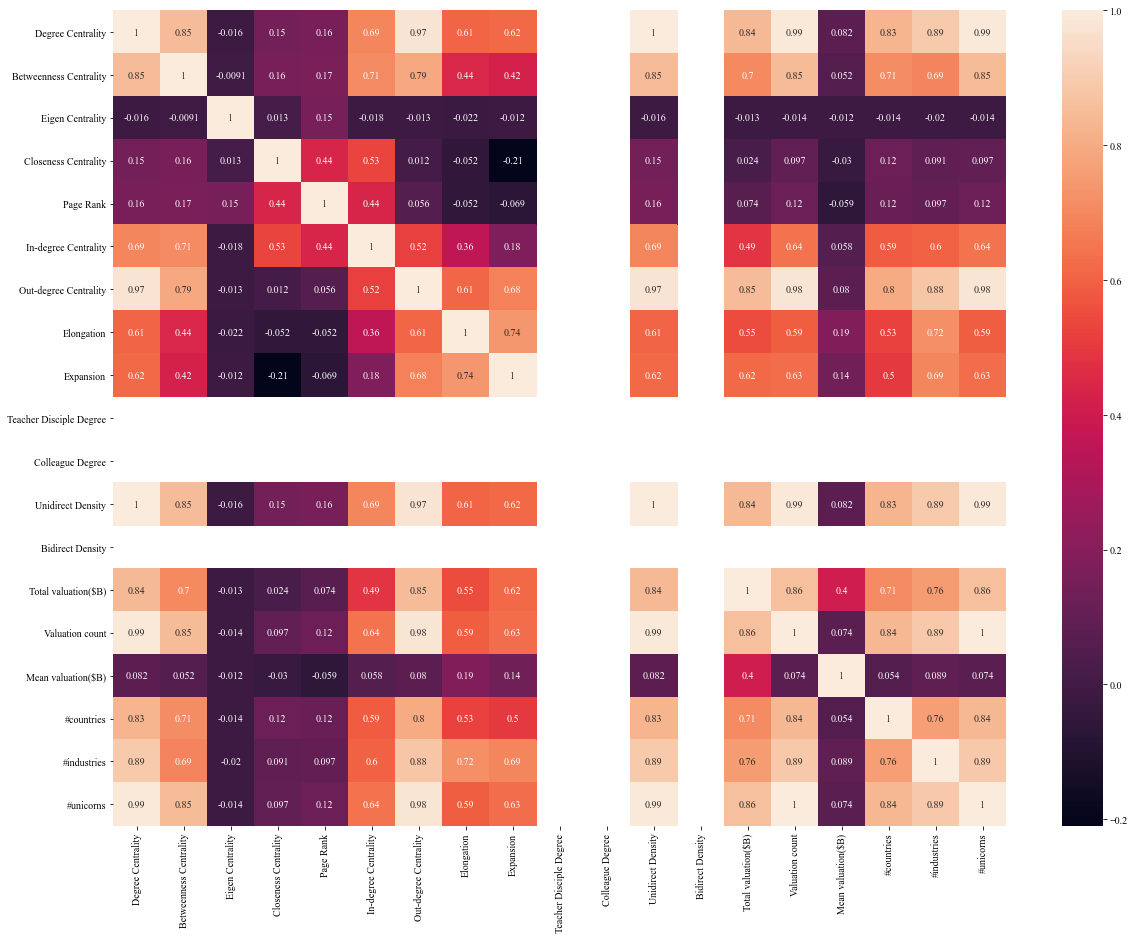

In [53]:
plt.figure(figsize=(20, 15))
sns.heatmap(investor_data_df.corr(), annot=True)
plt.savefig(os.path.join(out_dir, "features", "investor_correlation.png"))

In [54]:
value_df = df[["Company", "Valuation($B) flaot"]]
value_df.head()

,Company,Valuation($B) flaot
0,Bytedance,140.0
1,SpaceX,100.3
2,Stripe,95.0
3,Klarna,45.6
4,Epic Games,42.0


In [55]:
unicorn_data_df = pd.merge(comp_dgraph_centrality_df, value_df, on="Company", how="left").set_index("Company")

In [56]:
unicorn_data_df.head()

,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,Teacher Disciple Degree,...,Bidirect Density,Valuation ($B),Date Added,Country,Category,Select Investors,Valuation($B) flaot_x,DateTime Joined,Year Joined,Valuation($B) flaot_y
Company,,,,,,,,,,,,,,,,,,,,,
Databricks,0.078108,0.001145,3.117530e-81,0.034022,0.000569,0.020902,0.057206,8,488,1.0,...,0.0,$38.00,2019/2/5,United States,Data management & analytics,"[Andreessen Horowitz, New Enterprise Associat...",38.00,2019-02-05,2019,38.00
Everlaw,0.053905,0.000366,2.741248e-11,0.230789,0.001831,0.044004,0.009901,4,26,1.0,...,0.0,$2.00,2021/11/2,United States,Internet software & services,"[K9 Ventures, Menlo Ventures, Andreessen Hor...",2.00,2021-11-02,2021,2.00
Instabase,0.080308,0.002897,1.294344e-73,0.058129,0.000741,0.029703,0.050605,9,469,1.0,...,0.0,$1.05,2019/10/21,United States,Data management & analytics,"[New Enterprise Associates, Greylock Partners...",1.05,2019-10-21,2019,1.05
Phantom,0.050605,0.000000,1.776345e-03,0.296612,0.009640,0.050605,0.000000,0,0,1.0,...,0.0,$1.20,2022/1/31,United States,Fintech,"[Paradigm, Andreessen Horowitz, Jump Capital]",1.20,2022-01-31,2022,1.20
SnapLogic,0.048405,0.000050,4.542834e-07,0.243761,0.003488,0.044004,0.004400,3,11,1.0,...,0.0,$1.00,2021/12/13,United States,Internet software & services,"[Andreessen Horowitz, Triangle Peak Partners,...",1.00,2021-12-13,2021,1.00


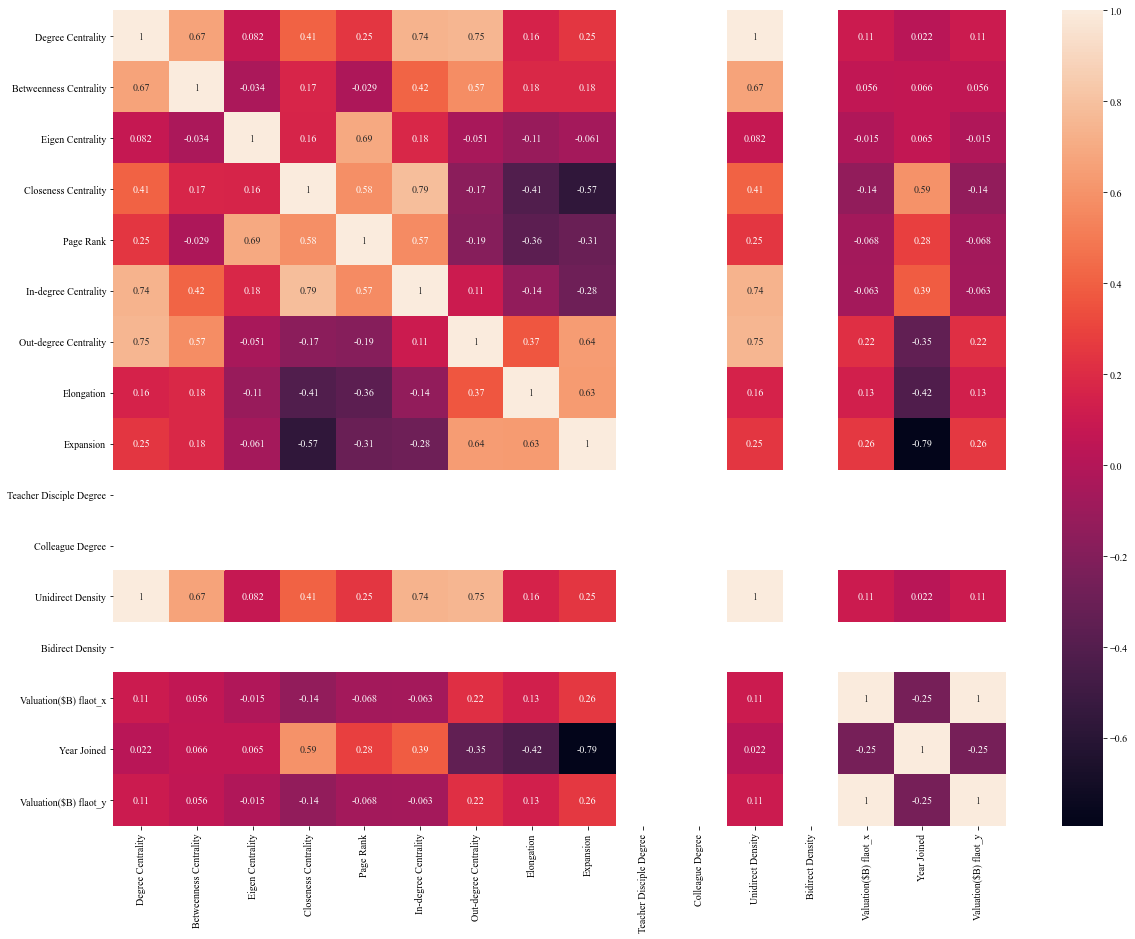

In [57]:
plt.figure(figsize=(20, 15))
sns.heatmap(unicorn_data_df.corr(), annot=True)
plt.savefig(os.path.join(out_dir, "features", "unicorn_correlation.png"))

valuationとユニコーン有向ネットワークの中心性との間に相関は見られない。

* 国ごと産業ごとの比較。
* 名寄せの問題。これは細かいので後回し
* 仮説を立てる。
  * VCのネットワークの意味は？
    * 何の関係を表してる？情報の流れ？
  * ユニコーンのネットワークの意味は？
    * 情報の流れ

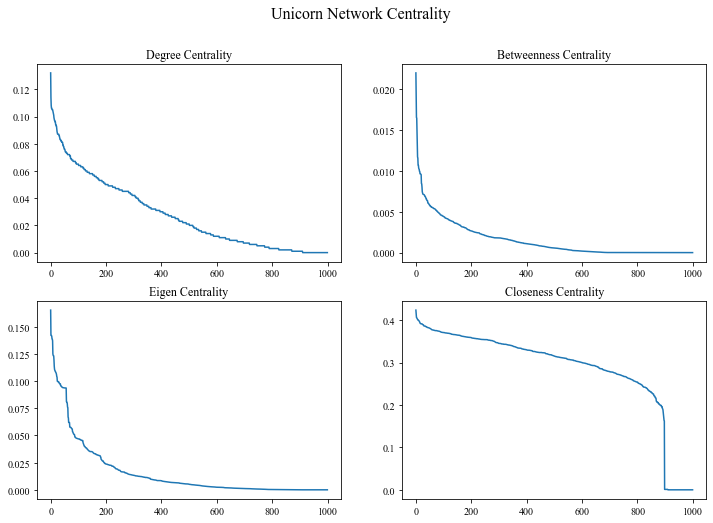

In [58]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle("Unicorn Network Centrality", fontsize=16)
ax1 = fig.add_subplot(221)
col = "Degree Centrality"
sorted_comp_cent_df = company_centrality_df.sort_values(col, ascending=False)
y = sorted_comp_cent_df[col]
x = list(range(len(sorted_comp_cent_df.index)))
ax1.set_title(col)
ax1.plot(x, y)
ax2 = fig.add_subplot(222)
col = "Betweenness Centrality"
sorted_comp_cent_df = company_centrality_df.sort_values(col, ascending=False)
y = sorted_comp_cent_df[col]
x = list(range(len(sorted_comp_cent_df.index)))
ax2.set_title(col)
ax2.plot(x, y)
ax3 = fig.add_subplot(223)
col = "Eigen Centrality"
sorted_comp_cent_df = company_centrality_df.sort_values(col, ascending=False)
y = sorted_comp_cent_df[col]
x = list(range(len(sorted_comp_cent_df.index)))
ax3.set_title(col)
ax3.plot(x, y)
ax4 = fig.add_subplot(224)
col = "Closeness Centrality"
sorted_comp_cent_df = company_centrality_df.sort_values(col, ascending=False)
y = sorted_comp_cent_df[col]
x = list(range(len(sorted_comp_cent_df.index)))
ax4.set_title(col)
ax4.plot(x, y)
plt.savefig(os.path.join(out_dir, "features", "unicorn_network_centrality.png"))

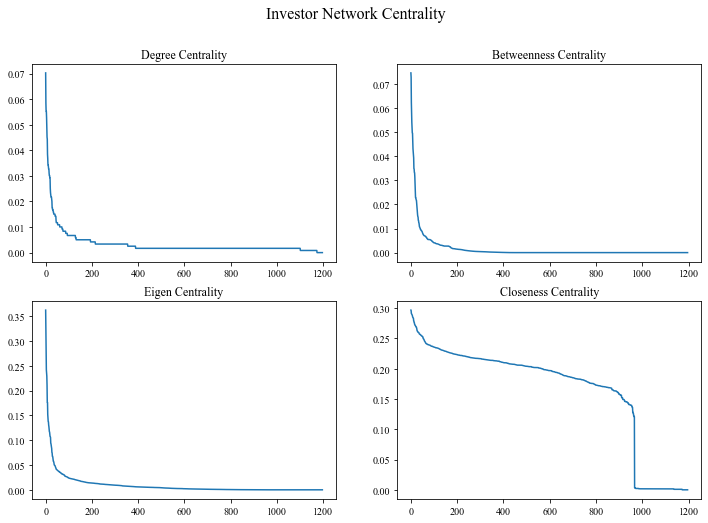

In [59]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle("Investor Network Centrality", fontsize=16)
ax1 = fig.add_subplot(221)
col = "Degree Centrality"
sorted_df = investor_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax1.set_title(col)
ax1.plot(x, y)
ax2 = fig.add_subplot(222)
col = "Betweenness Centrality"
sorted_df = investor_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax2.set_title(col)
ax2.plot(x, y)
ax3 = fig.add_subplot(223)
col = "Eigen Centrality"
sorted_df = investor_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax3.set_title(col)
ax3.plot(x, y)
ax4 = fig.add_subplot(224)
col = "Closeness Centrality"
sorted_df = investor_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax4.set_title(col)
ax4.plot(x, y)
plt.savefig(os.path.join(out_dir, "features", "investor_network_centrality.png"))

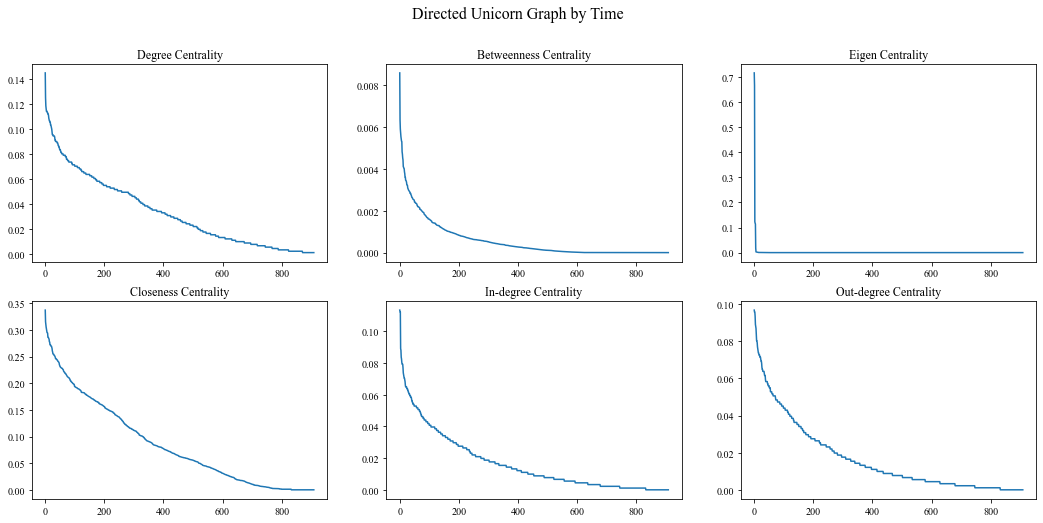

In [60]:
fig = plt.figure(figsize=(18, 8))
fig.suptitle("Directed Unicorn Graph by Time", fontsize=16)
ax1 = fig.add_subplot(231)
col = "Degree Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax1.set_title(col)
ax1.plot(x, y)
ax2 = fig.add_subplot(232)
col = "Betweenness Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax2.set_title(col)
ax2.plot(x, y)
ax3 = fig.add_subplot(233)
col = "Eigen Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax3.set_title(col)
ax3.plot(x, y)
ax4 = fig.add_subplot(234)
col = "Closeness Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax4.set_title(col)
ax4.plot(x, y)
ax5 = fig.add_subplot(235)
col = "In-degree Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax5.set_title(col)
ax5.plot(x, y)
ax6 = fig.add_subplot(236)
col = "Out-degree Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax6.set_title(col)
ax6.plot(x, y)
plt.savefig(os.path.join(out_dir, "features", "directed_unicorn_centrality.png"))

# データの出力

In [61]:
investor_centrality_df.to_csv(os.path.join(out_dir, "features", "investor_centrality.csv"))
company_centrality_df.to_csv(os.path.join(out_dir, "features", "unicorn_centrality.csv"))

In [62]:
unicorn_data_df.corr().to_csv(os.path.join(out_dir, "features", "unicorn_correlation.csv"))
investor_data_df.corr().to_csv(os.path.join(out_dir, "features", "investor_correlation.csv"))

## 企業 - 国・産業ネットワーク

In [63]:
df

,Company,Valuation ($B),Date Added,Country,Category,Select Investors,Valuation($B) flaot,DateTime Joined,Year Joined
0,Bytedance,$140.00,2017/4/7,China,Artificial intelligence,"[Sequoia Capital China, SIG Asia Investments,...",140.0,2017-04-07,2017
1,SpaceX,$100.30,2012/12/1,United States,Other,"[Founders Fund, Draper Fisher Jurvetson, Rot...",100.3,2012-12-01,2012
2,Stripe,$95.00,2014/1/23,United States,Fintech,"[Khosla Ventures, LowercaseCapital, capitalG]",95.0,2014-01-23,2014
3,Klarna,$45.60,2011/12/12,Sweden,Fintech,"[Institutional Venture Partners, Sequoia Capi...",45.6,2011-12-12,2011
4,Epic Games,$42.00,2018/10/26,United States,Other,"[Tencent Holdings, KKR, Smash Ventures]",42.0,2018-10-26,2018
...,...,...,...,...,...,...,...,...,...
995,Fever Labs,$1.00,2022/1/26,United States,Internet software & services,"[Accel, 14W, GS Growth]",1.0,2022-01-26,2022
996,Minio,$1.00,2022/1/26,United States,Data management & analytics,"[General Catalyst, Nexus Venture Partners, D...",1.0,2022-01-26,2022
997,Esusu,$1.00,2022/1/27,United States,Fintech,"[Next Play Ventures, Zeal Capital Partners, ...",1.0,2022-01-27,2022
998,Betterfly,$1.00,2022/2/1,Chile,Artificial intelligence,"[QED Investors, DST Global, Endeavor]",1.0,2022-02-01,2022


In [64]:
country_industry_df = pd.merge(comp_dgraph_df, df[["Company", "Country", "Category", "DateTime Joined"]], left_on="source", right_on="Company", how="left")
country_industry_df = pd.merge(country_industry_df, df[["Company", "Country", "Category", "DateTime Joined"]], left_on="target", right_on="Company", how="left", suffixes=["_source", "_target"])
country_industry_df = country_industry_df.drop(["Company_source", "Company_target"], axis=1)
country_industry_df.head()
country_industry_df.to_csv(os.path.join(out_dir, "edgelist", "country_industry_dgraph.csv"))

In [65]:
country_dgraph_df = country_industry_df.groupby(by=["Country_source", "Country_target"], as_index=False).agg({'source': 'count'})
country_dgraph_df.columns = ["source", "target", "weight"]
country_G = nx.from_pandas_edgelist(
    country_dgraph_df, create_using=nx.Graph, edge_attr=["weight"]
)
country_graph_df = nx.to_pandas_edgelist(country_G)
country_graph_df.to_csv(os.path.join(out_dir, "edgelist", "country_graph.csv"))
country_graph_matrix = nx.to_pandas_adjacency(country_G)
country_graph_matrix.to_csv(os.path.join(out_dir, "adjacency", "country_graph.csv"))

In [66]:
country_graph_matrix.max().max()

5380.0

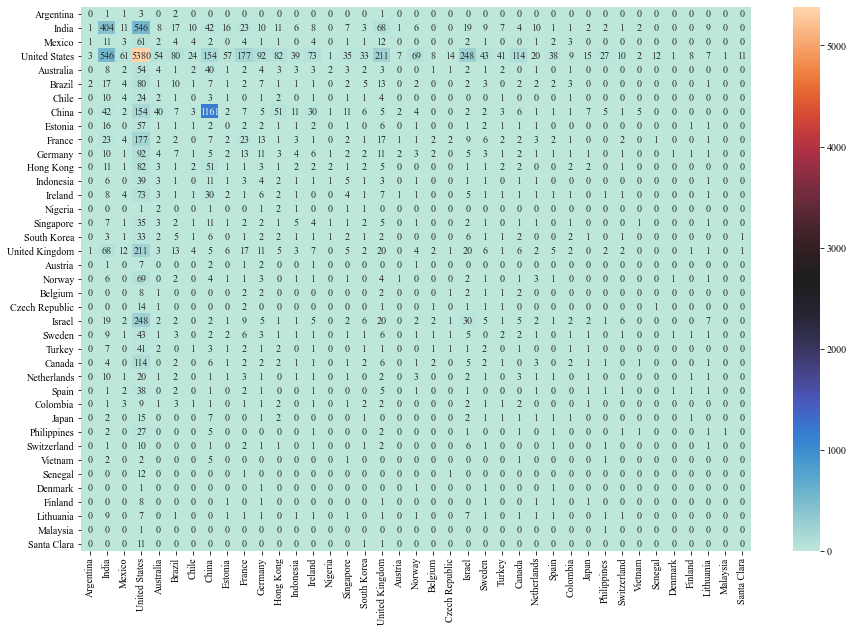

In [67]:
plt.figure(figsize=(15, 10))
center = (country_graph_matrix.max().max() - country_graph_matrix.min().min()) / 2
sns.heatmap(country_graph_matrix, center=center, annot=True, fmt=".0f")
plt.savefig(os.path.join(out_dir, "adjacency", "country_graph.png"))

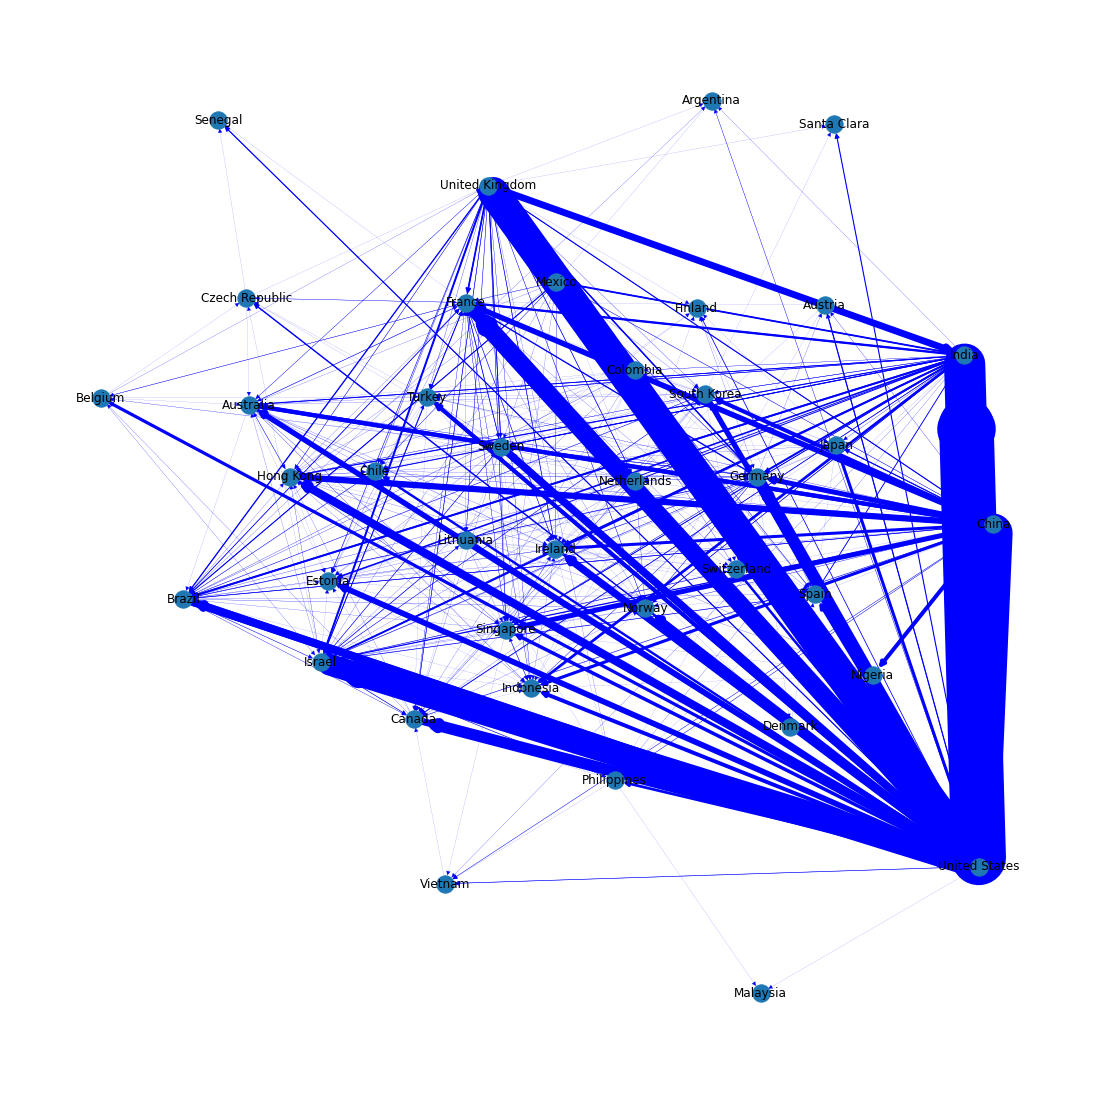

In [68]:
country_DG = nx.from_pandas_edgelist(
    country_dgraph_df, create_using=nx.DiGraph, edge_attr=["weight"]
)
edge_widths = [d['weight']/10 for _,_,d in country_DG.edges(data=True)]
plt.figure(figsize=(15, 15))
nx.draw(
    country_DG, width=edge_widths,
    pos=nx.kamada_kawai_layout(country_G),
    with_labels=True, edge_color="blue"
)
plt.savefig(os.path.join(out_dir, "edgelist", "country_dgraph.png"))
country_dgraph_df.to_csv(os.path.join(out_dir, "edgelist", "country_dgraph.csv"), sep="\t")

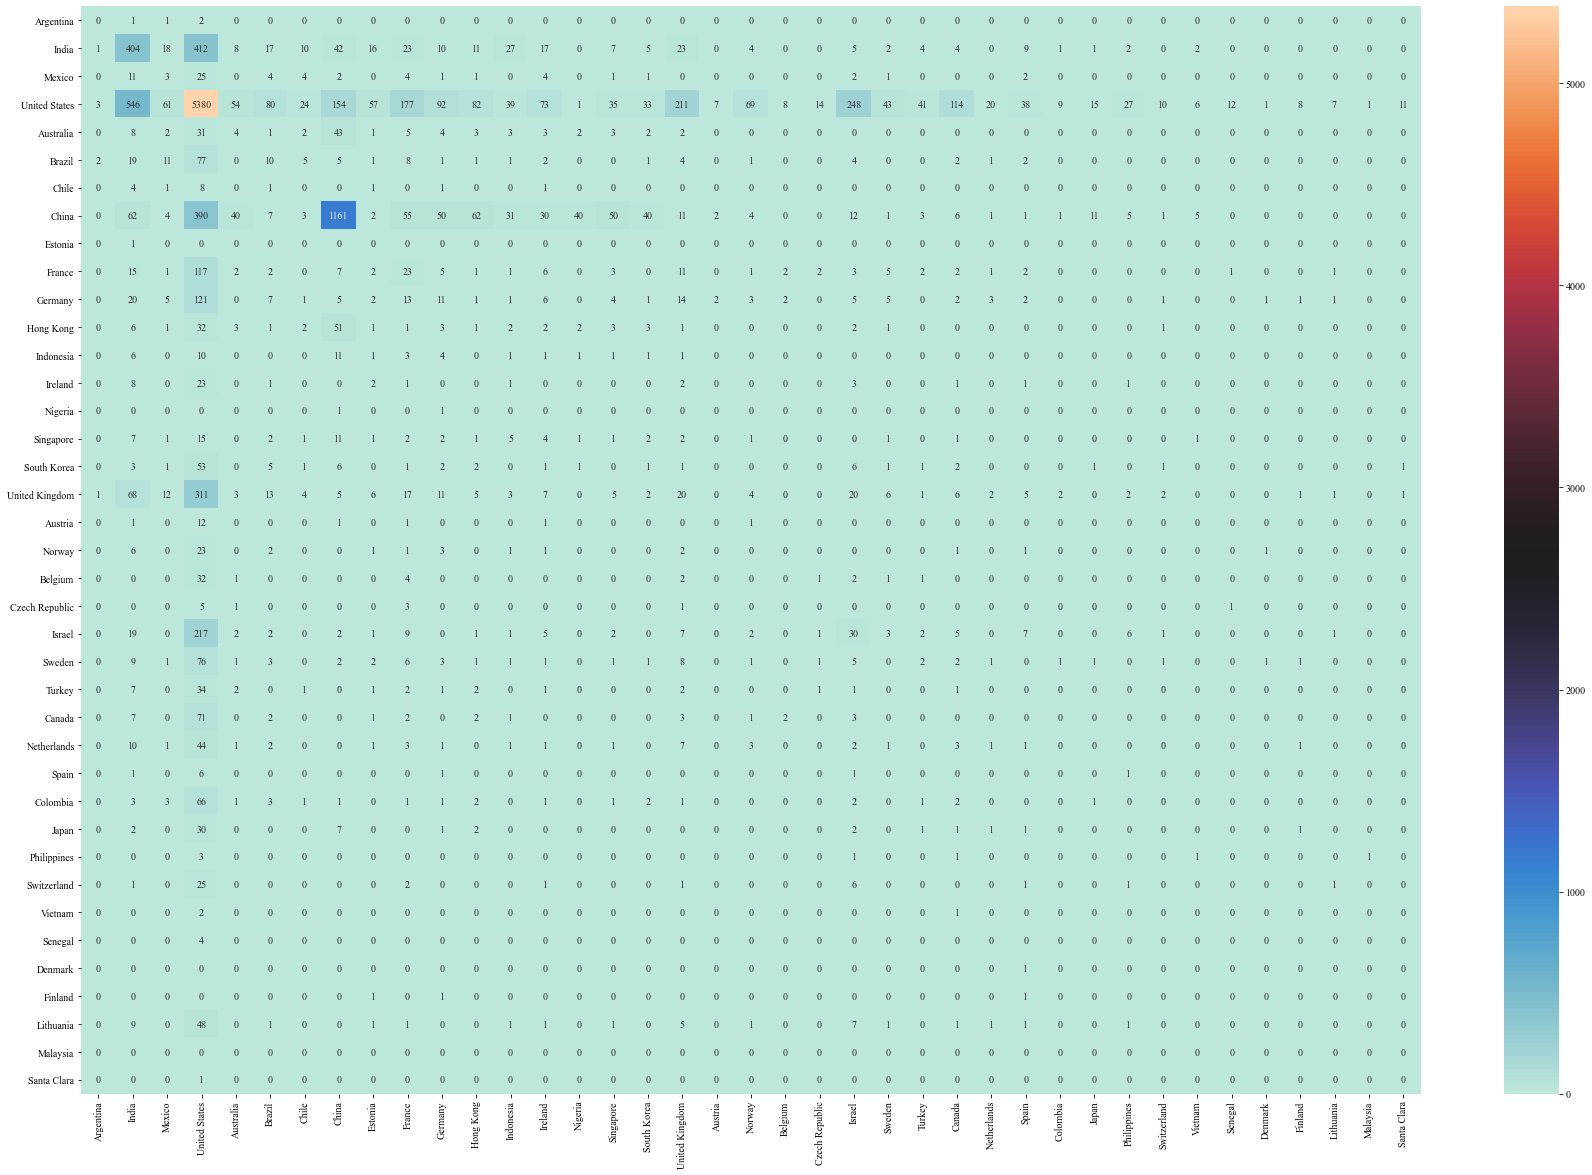

In [69]:
country_dgraph_matrix = nx.to_pandas_adjacency(country_DG)
plt.figure(figsize=(30, 20))
center = (country_dgraph_matrix.max().max() - country_dgraph_matrix.min().min()) / 2
sns.heatmap(country_dgraph_matrix, center=center, annot=True, fmt=".0f") # , annot_kws={"fontsize":3}
plt.savefig(os.path.join(out_dir, "adjacency", "country_dgraph.png"))
country_dgraph_matrix.to_csv(os.path.join(out_dir, "adjacency", "country_dgraph.csv"))

In [70]:
industry_dgraph_df = country_industry_df.groupby(by=["Category_source", "Category_target"], as_index=False).agg({"source": 'count'})
industry_dgraph_df.columns = ["source", "target", "weight"]
industry_G = nx.from_pandas_edgelist(industry_dgraph_df, create_using=nx.Graph, edge_attr="weight")
industry_graph_df = nx.to_pandas_edgelist(industry_G)
industry_graph_df.to_csv(os.path.join(out_dir, "edgelist", "industry_graph.csv"))
industry_graph_matrix = nx.to_pandas_adjacency(industry_G)
industry_graph_matrix.to_csv(os.path.join(out_dir, "adjacency", "industry_graph.csv"))
industry_graph_df.head()

,source,target,weight
0,Artificial intelligence,Artificial intelligence,90
1,Artificial intelligence,Auto & transportation,22
2,Artificial intelligence,Consumer & retail,42
3,Artificial intelligence,Cybersecurity,36
4,Artificial intelligence,Data management & analytics,71


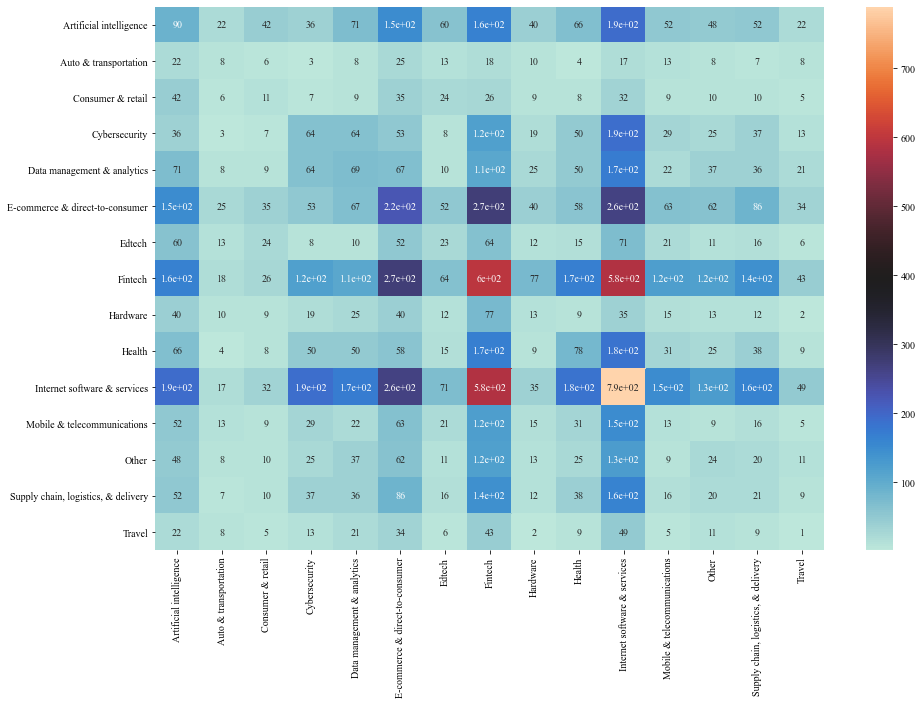

In [71]:
plt.figure(figsize=(15, 10))
center = (industry_graph_matrix.max().max() - industry_graph_matrix.min().min()) / 2
sns.heatmap(industry_graph_matrix, center=center, annot=True)
plt.savefig(os.path.join(out_dir, "adjacency", "industry_graph.png"))

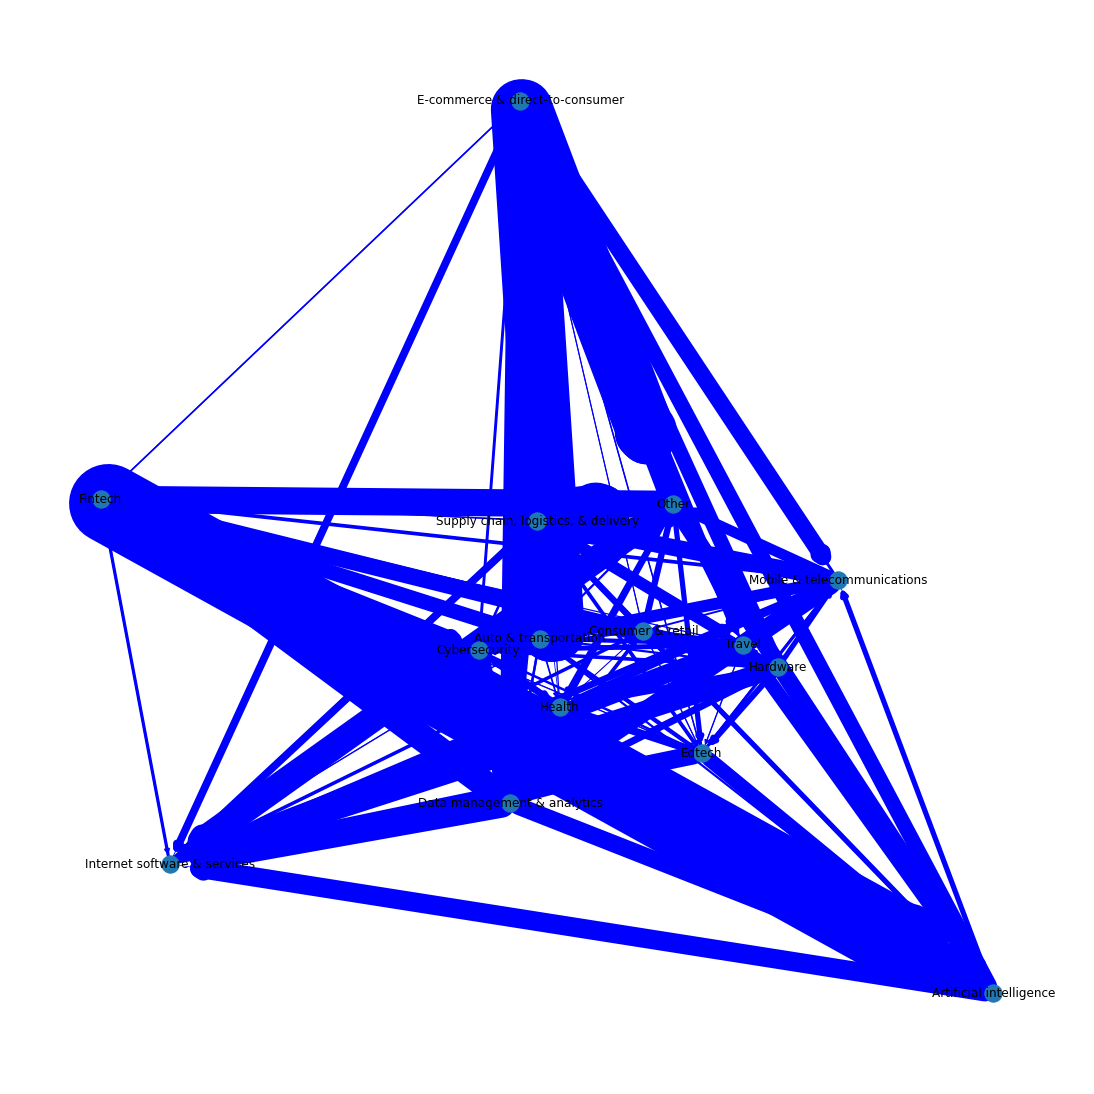

In [72]:
industry_DG = nx.from_pandas_edgelist(industry_dgraph_df, create_using=nx.DiGraph, edge_attr="weight")
edge_width = [v["weight"] * 0.1 for _, _, v in industry_G.edges(data=True)]
plt.figure(figsize=(15, 15))
nx.draw(
    industry_DG, width=edge_width, pos=nx.kamada_kawai_layout(industry_G),
    with_labels=True, edge_color="blue"
)
plt.savefig(os.path.join(out_dir, "edgelist", "industry_dgraph.png"))
industry_dgraph_df.to_csv(os.path.join(out_dir, "edgelist", "industry_dgraph.csv"), sep="\t")

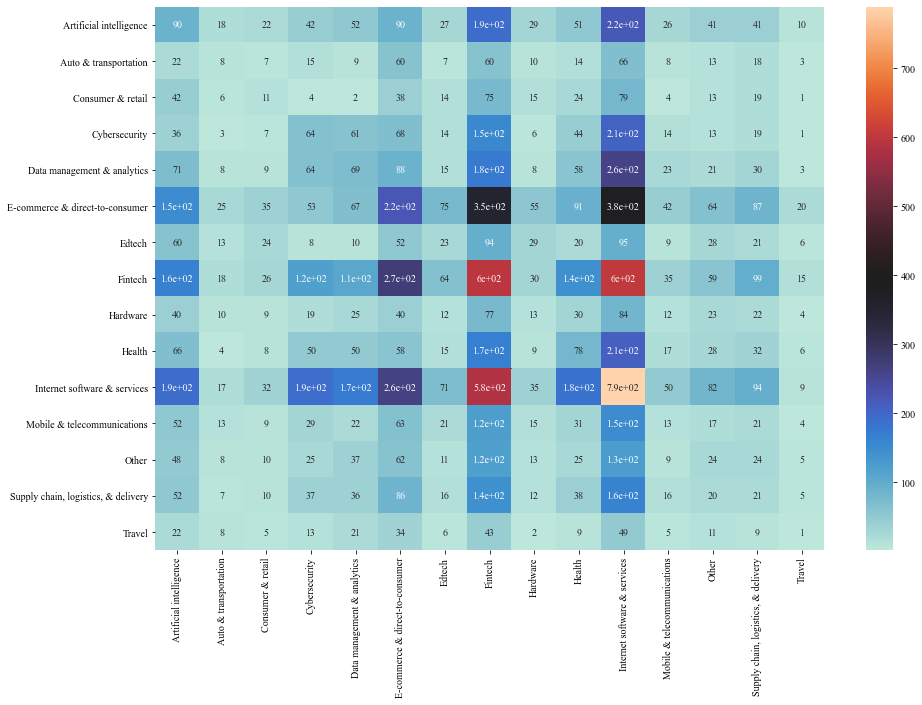

In [73]:
industry_dgraph_matrix = nx.to_pandas_adjacency(industry_DG)
plt.figure(figsize=(15, 10))
center = (industry_dgraph_matrix.max().max() - industry_dgraph_matrix.min().min()) / 2
sns.heatmap(industry_dgraph_matrix, center=center, annot=True)
plt.savefig(os.path.join(out_dir, "adjacency", "industry_dgraph.png"))
industry_dgraph_matrix.to_csv(os.path.join(out_dir, "adjacency", "industry_dgraph.csv"))

In [74]:
country_centrality_df = get_centrality(country_G)
industry_centrality_df = get_centrality(industry_G)

重み付きグラフです。
重み付きグラフです。


In [75]:
country_centrality_df.to_csv(os.path.join(out_dir, "features", "country_unicorn_centrality.csv"))

In [76]:
industry_centrality_df.to_csv(os.path.join(out_dir, "features", "industry_unicorn_centrality.csv"))

# 回帰分析

In [77]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

## ユニコーン回帰分析

In [78]:
unicorn_data_df.head()

,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,Teacher Disciple Degree,...,Bidirect Density,Valuation ($B),Date Added,Country,Category,Select Investors,Valuation($B) flaot_x,DateTime Joined,Year Joined,Valuation($B) flaot_y
Company,,,,,,,,,,,,,,,,,,,,,
Databricks,0.078108,0.001145,3.117530e-81,0.034022,0.000569,0.020902,0.057206,8,488,1.0,...,0.0,$38.00,2019/2/5,United States,Data management & analytics,"[Andreessen Horowitz, New Enterprise Associat...",38.00,2019-02-05,2019,38.00
Everlaw,0.053905,0.000366,2.741248e-11,0.230789,0.001831,0.044004,0.009901,4,26,1.0,...,0.0,$2.00,2021/11/2,United States,Internet software & services,"[K9 Ventures, Menlo Ventures, Andreessen Hor...",2.00,2021-11-02,2021,2.00
Instabase,0.080308,0.002897,1.294344e-73,0.058129,0.000741,0.029703,0.050605,9,469,1.0,...,0.0,$1.05,2019/10/21,United States,Data management & analytics,"[New Enterprise Associates, Greylock Partners...",1.05,2019-10-21,2019,1.05
Phantom,0.050605,0.000000,1.776345e-03,0.296612,0.009640,0.050605,0.000000,0,0,1.0,...,0.0,$1.20,2022/1/31,United States,Fintech,"[Paradigm, Andreessen Horowitz, Jump Capital]",1.20,2022-01-31,2022,1.20
SnapLogic,0.048405,0.000050,4.542834e-07,0.243761,0.003488,0.044004,0.004400,3,11,1.0,...,0.0,$1.00,2021/12/13,United States,Internet software & services,"[Andreessen Horowitz, Triangle Peak Partners,...",1.00,2021-12-13,2021,1.00


In [79]:
unicorn_data_df.columns

Index(['Degree Centrality', 'Betweenness Centrality', 'Eigen Centrality',
       'Closeness Centrality', 'Page Rank', 'In-degree Centrality',
       'Out-degree Centrality', 'Elongation', 'Expansion',
       'Teacher Disciple Degree', 'Colleague Degree', 'Unidirect Density',
       'Bidirect Density', 'Valuation ($B) ', 'Date Added', 'Country',
       'Category', 'Select Investors', 'Valuation($B) flaot_x',
       'DateTime Joined', 'Year Joined', 'Valuation($B) flaot_y'],
      dtype='object')

In [80]:
train_df = unicorn_data_df.drop([
    'Valuation ($B) ', 'Date Added', 'Country', 'Category', 'Select Investors',
    'DateTime Joined', 'Valuation($B) flaot_y', "Colleague Degree", "Bidirect Density",
    "Teacher Disciple Degree"
], axis=1)
# [
#     'Valuation($B)', 'Date Joined', 'Country', 'Industry', 'Select Investors', 'DateTime Joined', 'Valuation($B) flaot_y', 'Degree Centrality',
#     'Elongation', 'Expansion', 'Unidirect Density', 'Teacher Disciple Degree', 'Colleague Degree', 'Bidirect Density', 'In-degree Centrality',
#     'Page Rank'
# ] -> r2: 0.0615236981958418
d = ["Betweenness Centrality", "Elongation", "Page Rank", "Eigen Centrality",
     "Closeness Centrality", 'In-degree Centrality', "Degree Centrality", "Unidirect Density"]
train_df.drop(d, axis=1, inplace=True)
train_df.head()

,Out-degree Centrality,Expansion,Valuation($B) flaot_x,Year Joined
Company,,,,
Databricks,0.057206,488,38.00,2019
Everlaw,0.009901,26,2.00,2021
Instabase,0.050605,469,1.05,2019
Phantom,0.000000,0,1.20,2022
SnapLogic,0.004400,11,1.00,2021


<AxesSubplot:>

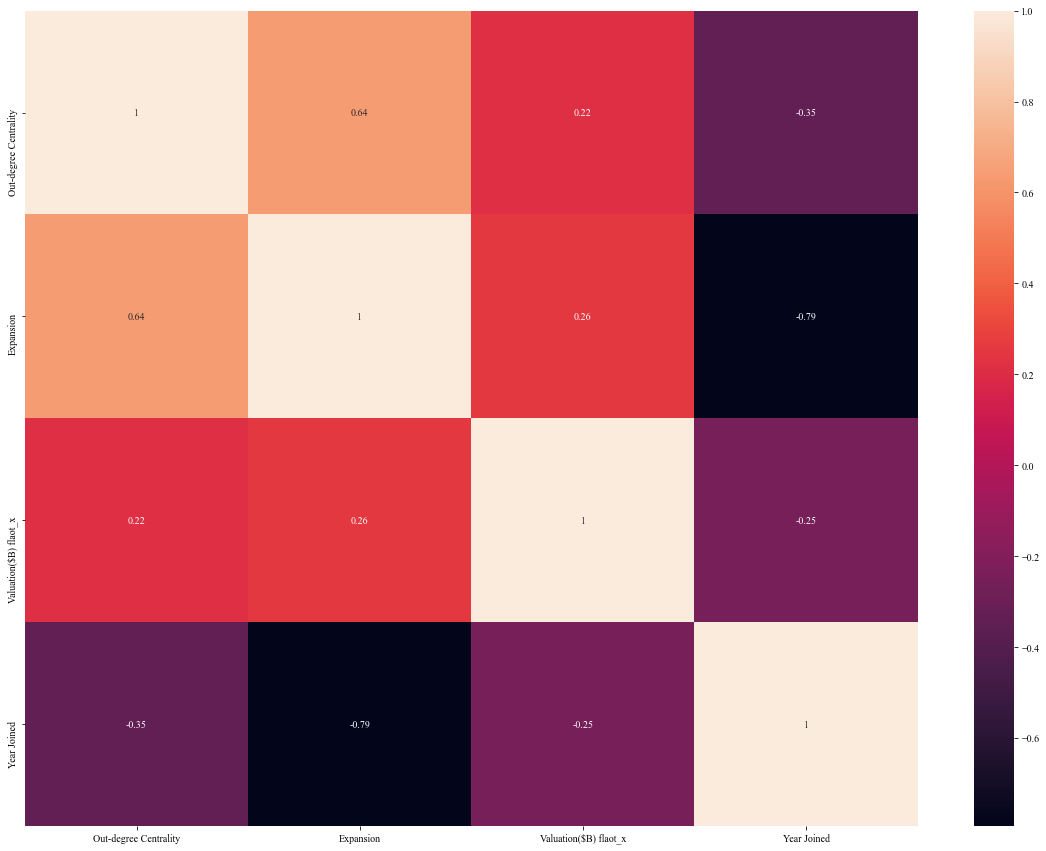

In [81]:
plt.figure(figsize=(20, 15))
sns.heatmap(train_df.corr(), annot=True)

In [82]:
sc = StandardScaler()
data_std = sc.fit_transform(train_df)
x, y = data_std[:,:-1], data_std[:, -1]
y = y.reshape(len(y), 1)
x_df = pd.DataFrame(x, columns=train_df.columns[:-1])
y_df = pd.DataFrame(y, columns=[train_df.columns[-1]])

In [83]:
mod = sm.OLS(y_df, sm.add_constant(x_df))
result = mod.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Year Joined   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     641.3
Date:                Sun, 27 Mar 2022   Prob (F-statistic):          1.68e-223
Time:                        11:47:50   Log-Likelihood:                -773.01
No. Observations:                 910   AIC:                             1554.
Df Residuals:                     906   BIC:                             1573.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.311e-14      0.019   6.97e-13      1.000      -0.037       0.037
Out-degree Centrality     0.2839      0.025     11.557      0.000       0.236       0.332
Expansion                -0.9587      0.025    -38.690      0.000      -1.007      -0.910
Valuation($B) flaot_x    -0.0669      0.020     -3.431      0.001      -0.105      -0.029
==============================================================================
Omnibus:                      477.018   Durbin-Watson:                   1.846
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4813.110
Skew:                          -2.176   Prob(JB):                         0.00
Kurtosis:                      13.393   Cond. No.                         2.23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [84]:
train_df.corr()

,Out-degree Centrality,Expansion,Valuation($B) flaot_x,Year Joined
Out-degree Centrality,1.000000,0.640925,0.221988,-0.345442
Expansion,0.640925,1.000000,0.256547,-0.793951
Valuation($B) flaot_x,0.221988,0.256547,1.000000,-0.249876
Year Joined,-0.345442,-0.793951,-0.249876,1.000000


In [85]:
np.sign(result.params[1:]) - np.sign(train_df.corr()["Valuation($B) flaot_x"][:-1].values)

Out-degree Centrality    0.0
Expansion               -2.0
Valuation($B) flaot_x   -2.0
dtype: float64

In [86]:
with open(os.path.join(out_dir, "features", "unicorn_regression.csv"), "w", encoding="utf-8") as f:
    f.write(result.summary().as_csv())

## VC回帰分析

In [87]:
investor_data_df.head()

,Investor,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,Teacher Disciple Degree,Colleague Degree,Unidirect Density,Bidirect Density,Total valuation($B),Valuation count,Mean valuation($B),#countries,#industries,#unicorns
0,Yunfeng Capital,0.004415,0.000100,1.122387e-16,0.015724,0.000824,0.001104,0.003311,2,6,1.0,0.0,0.002205,0.0,13.23,3,4.410000,1,3,3
1,Shang Qi Capital,0.001104,0.000000,3.042577e-15,0.012169,0.000991,0.001104,0.000000,0,0,1.0,0.0,0.000551,0.0,1.00,1,1.000000,1,1,1
2,Tencent Holdings,0.041943,0.003494,3.854413e-18,0.022935,0.002109,0.012141,0.029801,6,427,1.0,0.0,0.020948,0.0,156.90,28,5.603571,6,10,28
3,SDIC Innovation Investment Management,0.001104,0.000000,3.042577e-15,0.012169,0.000991,0.001104,0.000000,0,0,1.0,0.0,0.000551,0.0,1.00,1,1.000000,1,1,1
4,Hillhouse Capital Management,0.012141,0.000135,3.909567e-12,0.024991,0.001872,0.008830,0.003311,1,3,1.0,0.0,0.006064,0.0,41.28,8,5.160000,4,6,8


In [88]:
investor_data_df.describe()

,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,Teacher Disciple Degree,Colleague Degree,Unidirect Density,Bidirect Density,Total valuation($B),Valuation count,Mean valuation($B),#countries,#industries,#unicorns
count,907.000000,907.000000,9.070000e+02,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000,907.0,907.0,907.000000,907.0,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000
mean,0.004692,0.000111,1.422772e-03,0.014943,0.001103,0.002346,0.002346,1.134509,41.699008,1.0,0.0,0.002344,0.0,9.643076,2.797133,2.880392,1.487321,1.901874,2.797133
std,0.008691,0.000497,3.319226e-02,0.009383,0.000429,0.002257,0.007308,2.061845,146.568297,0.0,0.0,0.004341,0.0,25.404494,5.116811,4.171877,1.327500,1.817947,5.116811
min,0.001104,0.000000,1.105553e-42,0.000000,0.000758,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000551,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.001104,0.000000,1.081934e-24,0.007616,0.000815,0.001104,0.000000,0.000000,0.000000,1.0,0.0,0.000551,0.0,1.300000,1.000000,1.200000,1.000000,1.000000,1.000000
50%,0.002208,0.000000,3.041029e-15,0.015031,0.000934,0.002208,0.000000,0.000000,0.000000,1.0,0.0,0.001103,0.0,2.900000,1.000000,1.850000,1.000000,1.000000,1.000000
75%,0.004415,0.000015,8.044938e-10,0.022080,0.001219,0.002208,0.002208,1.000000,2.000000,1.0,0.0,0.002205,0.0,7.345000,2.000000,3.000000,1.000000,2.000000,2.000000
max,0.091611,0.006708,9.913948e-01,0.039313,0.003637,0.026490,0.072848,10.000000,800.000000,1.0,0.0,0.045755,0.0,341.880000,57.000000,71.500000,16.000000,13.000000,57.000000


In [90]:
investor_data_df = investor_data_df.set_index("Investor")
train_df = investor_data_df.drop(["Valuation count", "Mean valuation($B)", "Bidirect Density", "Colleague Degree", "Teacher Disciple Degree"], axis=1)
target = train_df["Total valuation($B)"]
train_df.drop("Total valuation($B)", axis=1, inplace=True)
train_df["Total valuation($B)"] = target
d = [
    "Degree Centrality", 'Closeness Centrality', 'Page Rank', 'Unidirect Density', '#countries', '#industries', "Elongation",
    'Eigen Centrality', 'In-degree Centrality', 'Out-degree Centrality'
]
train_df = train_df.drop(d, axis=1)
train_df.describe()

,Betweenness Centrality,Expansion,#unicorns,Total valuation($B)
count,907.000000,907.000000,907.000000,907.000000
mean,0.000111,41.699008,2.797133,9.643076
std,0.000497,146.568297,5.116811,25.404494
min,0.000000,0.000000,1.000000,1.000000
25%,0.000000,0.000000,1.000000,1.300000
50%,0.000000,0.000000,1.000000,2.900000
75%,0.000015,2.000000,2.000000,7.345000
max,0.006708,800.000000,57.000000,341.880000


In [92]:
# 前処理
sc = StandardScaler()
data_std = sc.fit_transform(train_df)
x, y = data_std[:,:-1], data_std[:, -1]
# y = sc.fit_transform(y)
y = y.reshape(len(y), 1)
x_df = pd.DataFrame(x, columns=train_df.columns[:-1])
y_df = pd.DataFrame(y, columns=[train_df.columns[-1]])
# モデル
mod = sm.OLS(y_df, sm.add_constant(x_df))
result = mod.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Total valuation($B)   R-squared:                       0.752
Model:                             OLS   Adj. R-squared:                  0.751
Method:                  Least Squares   F-statistic:                     910.8
Date:                 Sun, 27 Mar 2022   Prob (F-statistic):          1.65e-272
Time:                         11:47:50   Log-Likelihood:                -655.35
No. Observations:                  907   AIC:                             1319.
Df Residuals:                      903   BIC:                             1338.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -6.462e-17      0.017   -3.9e-15      1.000      -0.033       0.033
Betweenness Centrality    -0.0471      0.032     -1.454      0.146      -0.111       0.016
Expansion                  0.1248      0.022      5.655      0.000       0.081       0.168
#unicorns                  0.8220      0.038     21.825      0.000       0.748       0.896
==============================================================================
Omnibus:                     1149.415   Durbin-Watson:                   1.806
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           171526.290
Skew:                           6.510   Prob(JB):                         0.00
Kurtosis:                      69.100   Cond. No.                         4.44
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [93]:
train_df.columns[:-1]

Index(['Betweenness Centrality', 'Expansion', '#unicorns'], dtype='object')

In [94]:
np.sign(result.params[1:]) - np.sign(train_df.corr()["Total valuation($B)"][:-1].values)

Betweenness Centrality   -2.0
Expansion                 0.0
#unicorns                 0.0
dtype: float64

In [95]:
with open(os.path.join(out_dir, "features", "investor_regression.csv"), "w", encoding="utf-8") as f:
    f.write(result.summary().as_csv())

# unicornファイル間の比較

In [96]:
fpath = os.path.join("..", "data", "cb-insights_global-unicorn-club_2022.csv")
a_df = pd.read_csv(fpath, converters={"Select Investors": lambda x: x.split(",")})
a_df = preprocess(a_df, "%Y/%m/%d")
a_df.head()

,Company,Valuation ($B),Date Added,Country,Category,Select Investors,Valuation($B) flaot,DateTime Joined
0,Bytedance,$140.00,2017/4/7,China,Artificial intelligence,"[Sequoia Capital China, SIG Asia Investments,...",140.0,2017-04-07
1,SpaceX,$100.30,2012/12/1,United States,Other,"[Founders Fund, Draper Fisher Jurvetson, Rot...",100.3,2012-12-01
2,Stripe,$95.00,2014/1/23,United States,Fintech,"[Khosla Ventures, LowercaseCapital, capitalG]",95.0,2014-01-23
3,Klarna,$45.60,2011/12/12,Sweden,Fintech,"[Institutional Venture Partners, Sequoia Capi...",45.6,2011-12-12
4,Epic Games,$42.00,2018/10/26,United States,Other,"[Tencent Holdings, KKR, Smash Ventures]",42.0,2018-10-26


In [97]:
fpath = os.path.join("..", "data", "unicorn_company_invester.csv")
b_df = pd.read_csv(fpath, converters={"Select Investors": lambda x: x.split(",")})
b_df = preprocess(b_df, "%m/%d/%Y")
b_df.head()

,Company,Valuation ($B),Date Added,Country,Category,Select Investors,Valuation($B) flaot,DateTime Joined
0,100credit,$1,4/18/2018,China,Fintech,"[Sequoia Capital China, China Reform Fund, H...",1.0,2018-04-18
1,17zuoye,$1,3/7/2018,China,Edtech,"[DST Global, Temasek Holdings]",1.0,2018-03-07
2,23andMe,$2.50,7/3/2015,United States,Health,"[Google Ventures, New Enterprise Associates, ...",2.5,2015-07-03
3,4Paradigm,$2,12/19/2018,China,Artificial intelligence,"[Sequoia Capital China, China Construction Ba...",2.0,2018-12-19
4,58 Daojia,$1,10/12/2015,China,Internet software & services,"[KKR, Alibaba Group, Ping An Insurance]",1.0,2015-10-12


In [98]:
unicorn_a_set = set(a_df["Company"].values.tolist())
unicorn_b_set = set(b_df["Company"].values.tolist())
new_unicorn_set = unicorn_a_set - unicorn_b_set
out_unicorn_set = unicorn_b_set - unicorn_a_set
print("新しく追加されたユニコーン")
print(len(new_unicorn_set))
print("抜けたユニコーン")
print(len(out_unicorn_set))

新しく追加されたユニコーン
634
抜けたユニコーン
135


[]

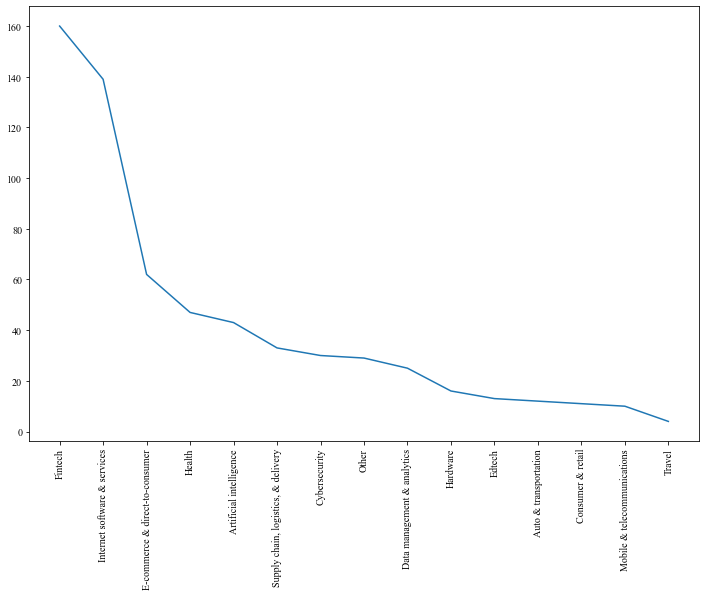

In [100]:
new_unicorn_df = a_df[a_df["Company"].isin(new_unicorn_set)]
vcount_new_unicorn_category = new_unicorn_df["Category"].value_counts()
vcount_new_unicorn_category.plot(figsize=(12, 8), fontsize=10, rot=90)
plt.xticks(list(range(len(vcount_new_unicorn_category))), vcount_new_unicorn_category.index)
plt.plot()

[]

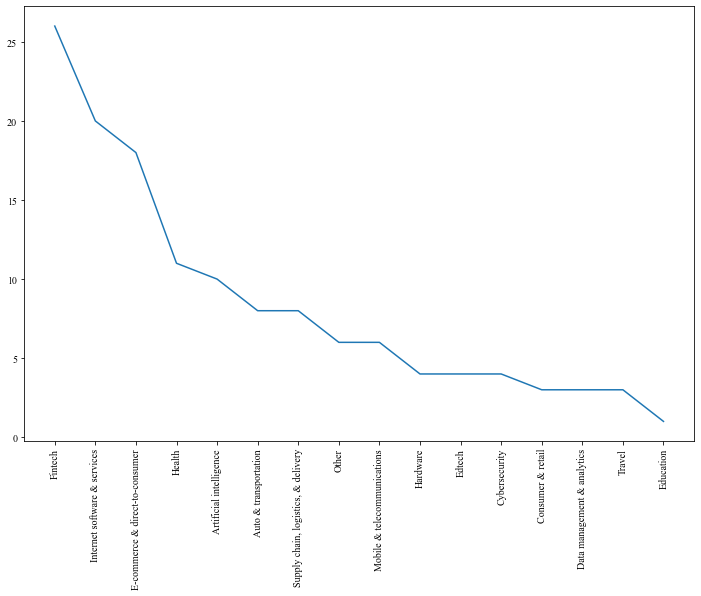

In [101]:
out_unicorn_df = b_df[b_df["Company"].isin(out_unicorn_set)]
vcount_out_unicorn_category = out_unicorn_df["Category"].value_counts()
vcount_out_unicorn_category.plot(figsize=(12, 8), fontsize=10, rot=90)
plt.xticks(list(range(len(vcount_out_unicorn_category))), vcount_out_unicorn_category.index)
plt.plot()

[]

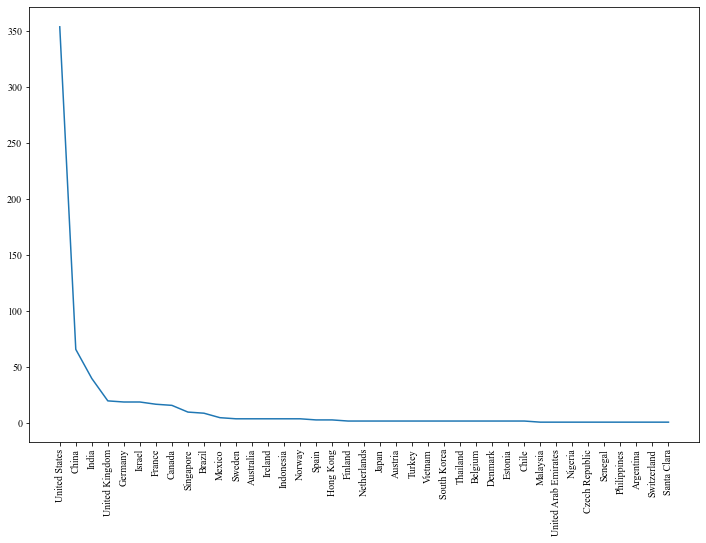

In [102]:
vcount_new_unicorn = new_unicorn_df["Country"].value_counts()
vcount_new_unicorn.plot(x=vcount_new_unicorn, rot=90, figsize=(12,8), fontsize=10)
plt.xticks(ticks=list(range(len(vcount_new_unicorn))), labels=vcount_new_unicorn.index.tolist())
plt.plot()

[]

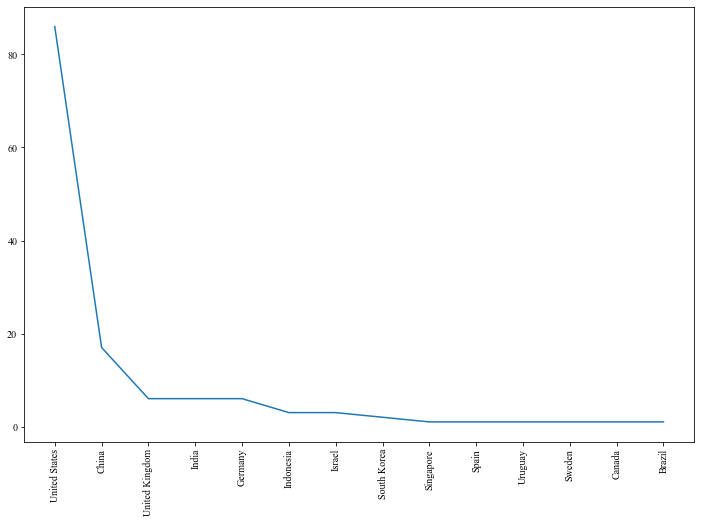

In [103]:
vcount_out_unicorn = out_unicorn_df["Country"].value_counts()
vcount_out_unicorn.plot(rot=90, figsize=(12,8), fontsize=10)
plt.xticks(ticks=list(range(len(vcount_out_unicorn))), labels=vcount_out_unicorn.index)
plt.plot()

In [104]:
a_df[a_df["Country"] == "Japan"]

,Company,Valuation ($B),Date Added,Country,Category,Select Investors,Valuation($B) flaot,DateTime Joined
389,Preferred Networks,$2.00,2018/5/17,Japan,Artificial intelligence,"[Toyota Motor Corporation, Mizuho Financial G...",2.00,2018-05-17
398,SmartNews,$2.00,2019/8/5,Japan,Mobile & telecommunications,"[Japan Post Capital, Globis Capital Partners,...",2.00,2019-08-05
503,SmartHR,$1.60,2021/6/8,Japan,Fintech,"[BEENEXT, World Innovation Lab, Light Street...",1.60,2021-06-08
656,Spiber,$1.22,2021/9/8,Japan,Other,"[Cool Japan Fund, JAFCO, The Carlyle Group]",1.22,2021-09-08
818,Liquid,$1.00,2019/4/3,Japan,Fintech,"[JAFCO Co, Bitmain Technologies, IDG Capital]",1.00,2019-04-03
838,Playco,$1.00,2020/9/21,Japan,Other,"[Sozo Ventures, Caffeinated Capital, Sequoia...",1.00,2020-09-21


In [105]:
b_df[b_df["Country"] == "Japan"]

,Company,Valuation ($B),Date Added,Country,Category,Select Investors,Valuation($B) flaot,DateTime Joined
256,Liquid,$1,4/3/2019,Japan,Fintech,"[JAFCO Co, Bitmain Technologies, IDG Capital]",1.0,2019-04-03
327,Playco,$1,9/21/2020,Japan,Other,"[Sozo Ventures, Caffeinated Capital, Sequoia...",1.0,2020-09-21
333,Preferred Networks,$2,5/17/2018,Japan,Artificial intelligence,"[Toyota Motor Corporation, Mizuho Financial G...",2.0,2018-05-17
382,SmartNews,$1.20,8/5/2019,Japan,Mobile & telecommunications,"[Japan Post Capital, Globis Capital Partners,...",1.2,2019-08-05


In [106]:
a_df.sort_values("Valuation($B) flaot", ascending=False).head(10)

,Company,Valuation ($B),Date Added,Country,Category,Select Investors,Valuation($B) flaot,DateTime Joined
0,Bytedance,$140.00,2017/4/7,China,Artificial intelligence,"[Sequoia Capital China, SIG Asia Investments,...",140.0,2017-04-07
1,SpaceX,$100.30,2012/12/1,United States,Other,"[Founders Fund, Draper Fisher Jurvetson, Rot...",100.3,2012-12-01
2,Stripe,$95.00,2014/1/23,United States,Fintech,"[Khosla Ventures, LowercaseCapital, capitalG]",95.0,2014-01-23
3,Klarna,$45.60,2011/12/12,Sweden,Fintech,"[Institutional Venture Partners, Sequoia Capi...",45.6,2011-12-12
4,Epic Games,$42.00,2018/10/26,United States,Other,"[Tencent Holdings, KKR, Smash Ventures]",42.0,2018-10-26
6,Checkout.com,$40.00,2019/5/2,United Kingdom,Fintech,"[Tiger Global Management, Insight Partners, ...",40.0,2019-05-02
5,Canva,$40.00,2018/1/8,Australia,Internet software & services,"[Sequoia Capital China, Blackbird Ventures, ...",40.0,2018-01-08
7,Instacart,$39.00,2014/12/30,United States,"Supply chain, logistics, & delivery","[Khosla Ventures, Kleiner Perkins Caufield & ...",39.0,2014-12-30
8,Databricks,$38.00,2019/2/5,United States,Data management & analytics,"[Andreessen Horowitz, New Enterprise Associat...",38.0,2019-02-05
9,Revolut,$33.00,2018/4/26,United Kingdom,Fintech,"[index Ventures, DST Global, Ribbit Capital]",33.0,2018-04-26


In [110]:
unicorn_investor_a_df = unicorn_investor_edgelist(a_df)
unicorn_investor_b_df = unicorn_investor_edgelist(b_df)
investor_a_set = set(unicorn_investor_a_df["Investor"].tolist())
investor_b_set = set(unicorn_investor_b_df["Investor"].tolist())

In [112]:
new_investor_set = investor_a_set - investor_b_set
out_investor_set = investor_b_set - investor_a_set
print("新しく追加された投資家")
print(len(new_investor_set))
print("抜けた投資家")
print(len(out_investor_set))

新しく追加された投資家
604
抜けた投資家
102


In [114]:
print(out_investor_set)

{'MassVentures', 'Learn Capital', 'Verlinvest', 'IP Group', 'Riverwood Capital', 'CapitalG', 'Sina Weibo Fund', 'Neuberger Berman', 'Index', 'Altitude Life Science Ventures', 'Basepoint Ventures', 'Amazon', 'Structure Capital', 'Propulsion Ventures', 'Makena Capital Management', 'S-Cubed Capital', 'Atlos Ventures', 'Foxconn', 'Tusk Ventures', 'DAG Ventures', 'Fonds de Solidarite FTQ', 'Composite Capital Partners', 'Benchmark Capital', 'Microsoft Ventures', 'Ford Motor Company', 'Unbound', 'Orient Hontai Capital', 'FinLab', 'Clal Industries and Investments', 'Lockheed Martin', 'Global Bridge Capital', 'Flare Capital Partners', 'Emtek Group', 'Batavia Incubator', 'Stonebridge Capital', 'Asian Development Bank', 'Franklin Square', 'Trilogy Equity Partners', 'QingSong Fund', 'Vertex Venture Holdings', 'Movile', 'GSV Capital', 'China Resources Holdings', 'Industry Ventures', 'Tribeca Venture Partners', 'MasterCard', 'Digital Currency Group', 'Freigeist Capital', 'Tokopedia_', 'Zhiping Capit

In [115]:
print(new_investor_set)

{'Alpargatas', 'HarbourVest Partners', 'Tru Arrow Partners', 'Coinbase Ventures', 'Standard Crypto', 'Invus Group', 'Valor Equity Partners', 'Pereg Ventures', 'BP Ventures', 'Vertex Ventures Israel', 'Alpha Wave Global', 'Hongtai Capital Holdings', 'CVC Capital Partners', 'Delian Capital', 'Deciens Capital', 'Elevation Capital', 'Bling Capital', 'BlueRun Ventures', 'Fairfax Financial Holdings', 'Accelm Scania Growth Capital', 'Hanwha Investment & Securities', 'Smilegate Investment', 'Carrick Capital Partners', 'McKesson Ventures', 'Oriental Fortune Capital', 'Presidio Ventures', 'Insignia Ventures Partners', 'Activant Capital', 'Noshaq', 'Doha Venture Capital', 'Augmentum Fintech', 'Sunley House Capital Management', 'Point72 Ventures', 'Kae Capital', 'Ally Bridge Group', 'Loeb.NYC', 'Ideal International', 'TriplePoint Capital', 'XBTO Ventures', 'India Quotient', 'HD Capital', 'Jove Equity Partners', 'TDR Capital', 'BECO Capital', 'Geely', 'Multicoin Capital', "L'Occitane", 'OrbiMed Adv